In [1]:
import sys, os
sys.path.insert(0, "{}/StarNet".format(os.getenv('HOME')))
import numpy as np
import h5py
import random
import matplotlib
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns
import json
import glob
import csv
import tensorflow as tf
import keras
import time
from isochrones.mist import MIST_Isochrone
from keras.models import load_model, Model
from astropy.io import fits as pyfits
 
from starnet.utils.data_utils.augment import convolve_spectrum, mask_tellurics, fastRotBroad, add_radial_velocity
from starnet.utils.data_utils.restructure_spectrum import rebin, continuum_normalize, ensure_constant_sampling
from starnet.utils.data_utils.loading import load_data_from_h5, get_synth_spec_data, get_synth_wavegrid
from starnet.utils.nn_utils.custom_layers import GaussianLayer
from starnet.utils.nn_utils.deep_ensemble import denormalize_mu, denormalize_sigma, get_model_training_info, \
mad_based_outlier, load_ensemble, ensemble_predict
from starnet.utils.plotting import plot_compare_estimates_gaiaeso_resid, make_boxplots_splitSNR
from starnet.models.cnn_models import StarNet2017, StarNet2017DeepEnsemble

/home/merileo/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/merileo/py36/lib/python3.6/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/home/merileo/py36/lib/python3.6/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/home/merileo/py36/lib/python3.6/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for ftp://ftp.stsci.edu/cdbs/mtab/*_tmg.fits
  'functionality wil

In [2]:
plt.rcParams['axes.grid']=True
plt.rcParams['grid.color']='gray'
plt.rcParams['grid.alpha']='0.4'
plt.rcParams["text.usetex"] = True

In [3]:
# Define parameters needed for continuum fitting
LINE_REGIONS = [[4210, 4240], [4250, 4410], [4333, 4388], [4845, 4886], [5160, 5200], [5874, 5916], [6530, 6590]]
SEGMENTS_STEP = 10.  # divide the spectrum into segments of 10 Angstroms

## Define folder names

In [4]:
home = os.getenv('HOME')
scratch = os.getenv('SCRATCH')

preprocessed_spectra_path = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/preprocessed/')
intrigoss_grid_path = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/grids/intrigoss/')
starnet_data_folder = os.path.join(home, 'StarNet/starnet/data/')

#ensemble_folder = 'StarNet2017DeepEnsemble_ambre_vrad200_vrot70_6labels_n100000'
#ensemble_folder = 'intrigoss_uves_4labels_deepensemble_firstrun/'
#ensemble_folder = 'StarNet2017DeepEnsemble_intrigoss_vrad200_vrot70_6labels_finaltest'
#ensemble_folder = 'StarNet2017DeepEnsemble_intrigoss_vrad200_vrot70_6labels_finaltest_n10000_olddset'
#ensemble_folder = 'StarNet2017DeepEnsemble_intrigoss_vrad200_vrot70_6labels_finaltest_n50000_olddset'
#ensemble_folder = 'StarNet2017DeepEnsemble_intrigoss_vrad200_vrot70_6labels_finaltest_n100000_olddset'
ensemble_folder = 'StarNet2017DeepEnsemble_intrigoss_vrad200_vrot70_6labels_finaltest_n100000_gaussiansmooth'
#ensemble_folder = 'StarNet2017DeepEnsemble_intrigoss_vrad200_vrot70_6labels_finaltest_n100000_olddset_2'
#ensemble_folder = 'StarNet2017DeepEnsemble_intrigoss_vrad200_vrot70_6labels_finaltest_n100000_olddset_shuffled'
#ensemble_folder = 'StarNet2017DeepEnsemble_intrigoss_vrad200_vrot70_6labels_n100000_shuffled_vrotvradfirst'
#ensemble_folder = 'StarNet2017DeepEnsemble_intrigoss_vrad200_vrot70_6labels_finaltest_n100000_shuffled_allintrigoss'
#ensemble_folder = 'StarNet2017DeepEnsemble_intrigoss_vrad200_vrot70_6labels_finaltest_n150000_olddset'
#ensemble_folder = 'StarNet2017DeepEnsemble_intrigoss_vrad200_vrot70_6labels_finaltest_n250000_olddset'
#ensemble_folder = 'StarResNetDeepEnsemble_intrigoss_vrad200_vrot70_6labels_finaltest'
#ensemble_folder = 'StarResNetDeepEnsemble_intrigoss_vrad200_vrot70_6labels_n250000_newvrad_maxpool'
#ensemble_folder = 'StarResNetDeepEnsemble_intrigoss_vrad200_vrot70_6labels_n300000_newvrad_maxpool'
#ensemble_folder = 'StarNet2017DeepEnsemble_intrigoss_vrad200_vrot70_4labels_finaltest'
ensemble_path = os.path.join(scratch, ensemble_folder)

### Load ensemble of models for making predictions

In [5]:
# Load the ensemble of models
ensemble, mu_labels, sigma_labels = load_ensemble(ensemble_path, maximum_loss_accepted=3.5, top_n=7)

# Get h5 keywords from one of the model folders
_, _, targets, spec_name = get_model_training_info(glob.glob(ensemble_path + '/*')[0])

Loading model: model3
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Loading model: model0
Loading model: model2
Loading model: model13
Loading model: model9
Loading model: model1
Loading model: model6
The ensemble contains 7 models with the following validation losses: 
(2.2414336033327147, 2.3747962240052587, 2.379270133810981, 2.3898213443571072, 2.3962059464499, 2.40071123368097, 2.4341120168630783)


## Load INTRIGOSS test set

In [12]:
data_filename = 'intrigoss_testset_oldvrad.h5'
data_file = os.path.join(preprocessed_spectra_path, data_filename)

start_indx=0
end_indx=3000
data = load_data_from_h5(data_file=data_file,
                         start_indx=start_indx,
                         end_indx=end_indx,
                         target_name=targets,
                         spec_name=spec_name,
                         wave_grid_key='wave_grid',
                         noise_key='noise')

X_synth_intri, y_synth_intri, noise_synth_intri, wave_grid = data.X, data.y, data.noise, data.wave_grid

# Mask telluric lines
X_synth_intri = mask_tellurics(os.path.join(starnet_data_folder, 'telluric_lines.txt'), X_synth_intri, wave_grid)

only non-normalized labels will be returned!


## Load AMBRE test set

In [13]:
data_filename = 'ambre_testset_intrigossparams_oldvrad.h5'
data_file = os.path.join(preprocessed_spectra_path, data_filename)

start_indx=0
end_indx=3000
data = load_data_from_h5(data_file=data_file,
                         start_indx=start_indx,
                         end_indx=end_indx,
                         target_name=targets,
                         spec_name=spec_name,
                         wave_grid_key='wave_grid',
                         noise_key='noise')

X_synth_ambre, y_synth_ambre, noise_synth_ambre, wave_grid = data.X, data.y, data.noise, data.wave_grid

# Mask telluric lines
X_synth_ambre = mask_tellurics(os.path.join(starnet_data_folder, 'telluric_lines.txt'), X_synth_ambre, wave_grid)

only non-normalized labels will be returned!


## Load Ferre test set

In [14]:
data_filename = 'ferre_300k_intrigossparams_uves_n5000.h5'
data_file = os.path.join(preprocessed_spectra_path, data_filename)

start_indx=0
end_indx=3000
data = load_data_from_h5(data_file=data_file,
                         start_indx=start_indx,
                         end_indx=end_indx,
                         target_name=targets,
                         spec_name=spec_name,
                         wave_grid_key='wave_grid',
                         noise_key='noise')

X_synth_ferre, y_synth_ferre, noise_synth_ferre, wave_grid = data.X, data.y, data.noise, data.wave_grid

# Mask telluric lines
X_synth_ferre = mask_tellurics(os.path.join(starnet_data_folder, 'telluric_lines.txt'), X_synth_ferre, wave_grid)

only non-normalized labels will be returned!


## Load Phoenix test sets (one with the same parameter range as INTRIGOSS, the other the full parameter range of Phoenix)

In [15]:
data_filename_intriparams = 'phoenix_testset_intrigossparams_oldvrad.h5'
data_filename_fullparams = 'phoenix_testset_full_oldvrad.h5'
start_indx=0
end_indx=3000

data_file = os.path.join(preprocessed_spectra_path, data_filename_intriparams)
data = load_data_from_h5(data_file=data_file,
                         start_indx=start_indx,
                         end_indx=end_indx,
                         target_name=targets,
                         spec_name=spec_name,
                         wave_grid_key='wave_grid',
                         noise_key='noise')
X_synth_phoenix, y_synth_phoenix, noise_synth_phoenix, wave_grid = data.X, data.y, data.noise, data.wave_grid

data_file = os.path.join(preprocessed_spectra_path, data_filename_fullparams)
data = load_data_from_h5(data_file=data_file,
                         start_indx=start_indx,
                         end_indx=end_indx,
                         target_name=targets,
                         spec_name=spec_name,
                         wave_grid_key='wave_grid',
                         noise_key='noise')
X_synth_phoenix_full, y_synth_phoenix_full, noise_synth_phoenix_full, wave_grid = data.X, data.y, data.noise, data.wave_grid

# Mask telluric lines
X_synth_phoenix = mask_tellurics(os.path.join(starnet_data_folder, 'telluric_lines.txt'), X_synth_phoenix, wave_grid)
X_synth_phoenix_full = mask_tellurics(os.path.join(starnet_data_folder, 'telluric_lines.txt'), X_synth_phoenix_full, wave_grid)

only non-normalized labels will be returned!
only non-normalized labels will be returned!


## Load intramesh INTRIGOSS test set

In [16]:
off_grid_files = glob.glob(os.path.join(intrigoss_grid_path, 'off_grid_spectra/*f.fits'))

In [20]:
obs_wave_filepath = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/UVES_4835-5395.npy')
wave_grid_obs = np.load(obs_wave_filepath)

# Collect spectra data
off_grid_X = []
off_grid_y = []
for off_grid_file in off_grid_files:
    flux, params = get_synth_spec_data(off_grid_file, grid_name='intrigoss')
    wave_grid_intrigoss = get_synth_wavegrid(off_grid_file, grid_name='intrigoss')
    
    # Trim the wavelength and flux arrays according to observed wave grid
    extension = 10  # Angstroms
    wave_min_request = wave_grid_obs[0] - extension
    wave_max_request = wave_grid_obs[-1] + extension
    wave_indices = (wave_grid_intrigoss > wave_min_request) & (wave_grid_intrigoss < wave_max_request)
    wave_grid_intrigoss = wave_grid_intrigoss[wave_indices]
    flux = flux[wave_indices]

    # Degrade resolution
    err_intrigoss = np.zeros(len(flux))
    _, flux, _ = convolve_spectrum(wave_grid_intrigoss, flux, err_intrigoss, to_resolution=47000)
        
    
    # Apply rotational broadening
    epsilon = random.uniform(0, 1.)
    vrot = random.uniform(0, 30)  # km/s
    params.append(vrot)
    flux = fastRotBroad(wave_grid_intrigoss, flux, epsilon, vrot)

    # Add radial velocity
    vrad = random.uniform(-150, 150)  # km/s
    params.append(vrad)
    rv_wav = add_radial_velocity(wave_grid_intrigoss, vrad)

    # Rebin to UVES wave grid
    flux = rebin(wave_grid_obs, rv_wav, flux)

    t0 = time.time()
    # Continuum normalize the spectra
    flux, _ = continuum_normalize(flux, wave_grid_obs, fit='gaussian_smooth')
                                  #line_regions=LINE_REGIONS,
                                  #segments_step=SEGMENTS_STEP)
    print('Take taken for cont: {:.2f}s'.format(time.time() - t0))

    off_grid_X.append(flux)
    off_grid_y.append(params)

Take taken for cont: 32.78s
Take taken for cont: 32.78s
Take taken for cont: 32.74s
Take taken for cont: 32.74s
Take taken for cont: 32.74s
Take taken for cont: 32.78s
Take taken for cont: 32.73s
Take taken for cont: 32.97s
Take taken for cont: 32.74s
Take taken for cont: 32.81s
Take taken for cont: 32.83s
Take taken for cont: 32.82s
Take taken for cont: 32.75s
Take taken for cont: 32.80s
Take taken for cont: 32.79s
Take taken for cont: 32.80s
Take taken for cont: 32.79s
Take taken for cont: 32.86s
Take taken for cont: 32.82s
Take taken for cont: 32.78s
Take taken for cont: 32.74s
Take taken for cont: 32.84s
Take taken for cont: 32.80s
Take taken for cont: 32.76s
Take taken for cont: 32.81s
Take taken for cont: 32.71s
Take taken for cont: 32.83s
Take taken for cont: 32.69s
Take taken for cont: 32.77s
Take taken for cont: 32.75s
Take taken for cont: 32.75s
Take taken for cont: 32.69s
Take taken for cont: 32.74s
Take taken for cont: 32.71s
Take taken for cont: 32.68s
Take taken for cont:

## Tests on INTRIGOSS, AMBRE, and Phoenix datasets to see how uncertainties differ between the three datasets

In [22]:
# Predict on synthetic spectra
mu_test_intri, sigma_test_intri = ensemble_predict(X_synth_intri, ensemble=ensemble, mu_labels=mu_labels, 
                                                   sigma_labels=sigma_labels)
mu_test_ambre, sigma_test_ambre = ensemble_predict(X_synth_ambre, ensemble=ensemble, mu_labels=mu_labels, 
                                                   sigma_labels=sigma_labels)
mu_test_ferre, sigma_test_ferre = ensemble_predict(X_synth_ferre, ensemble=ensemble, mu_labels=mu_labels, 
                                                   sigma_labels=sigma_labels)
mu_test_phoenix, sigma_test_phoenix = ensemble_predict(X_synth_phoenix, ensemble=ensemble, mu_labels=mu_labels, 
                                                       sigma_labels=sigma_labels)
mu_test_phoenix_full, sigma_test_phoenix_full = ensemble_predict(X_synth_phoenix_full, ensemble=ensemble, 
                                                                 mu_labels=mu_labels, sigma_labels=sigma_labels)

Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained models...
Done! You now have the final predictions with uncertainties.
Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained models...
Done! You now have the final predictions with uncertainties.
Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained models...
Done! You now have the final predictions with uncertainties.
Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained models...
Done! You now have the final predictions with uncertainties.
Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained models...


/home/merileo/StarNet/starnet/utils/nn_utils/deep_ensemble.py:64: RuntimeWarning: divide by zero encountered in true_divide
  modified_z_score = 0.6745 * diff / med_abs_deviation
/home/merileo/StarNet/starnet/utils/nn_utils/deep_ensemble.py:64: RuntimeWarning: invalid value encountered in true_divide
  modified_z_score = 0.6745 * diff / med_abs_deviation
/home/merileo/StarNet/starnet/utils/nn_utils/deep_ensemble.py:66: RuntimeWarning: invalid value encountered in greater
  return modified_z_score > thresh


Done! You now have the final predictions with uncertainties.


/home/merileo/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


<IPython.core.display.Javascript object>


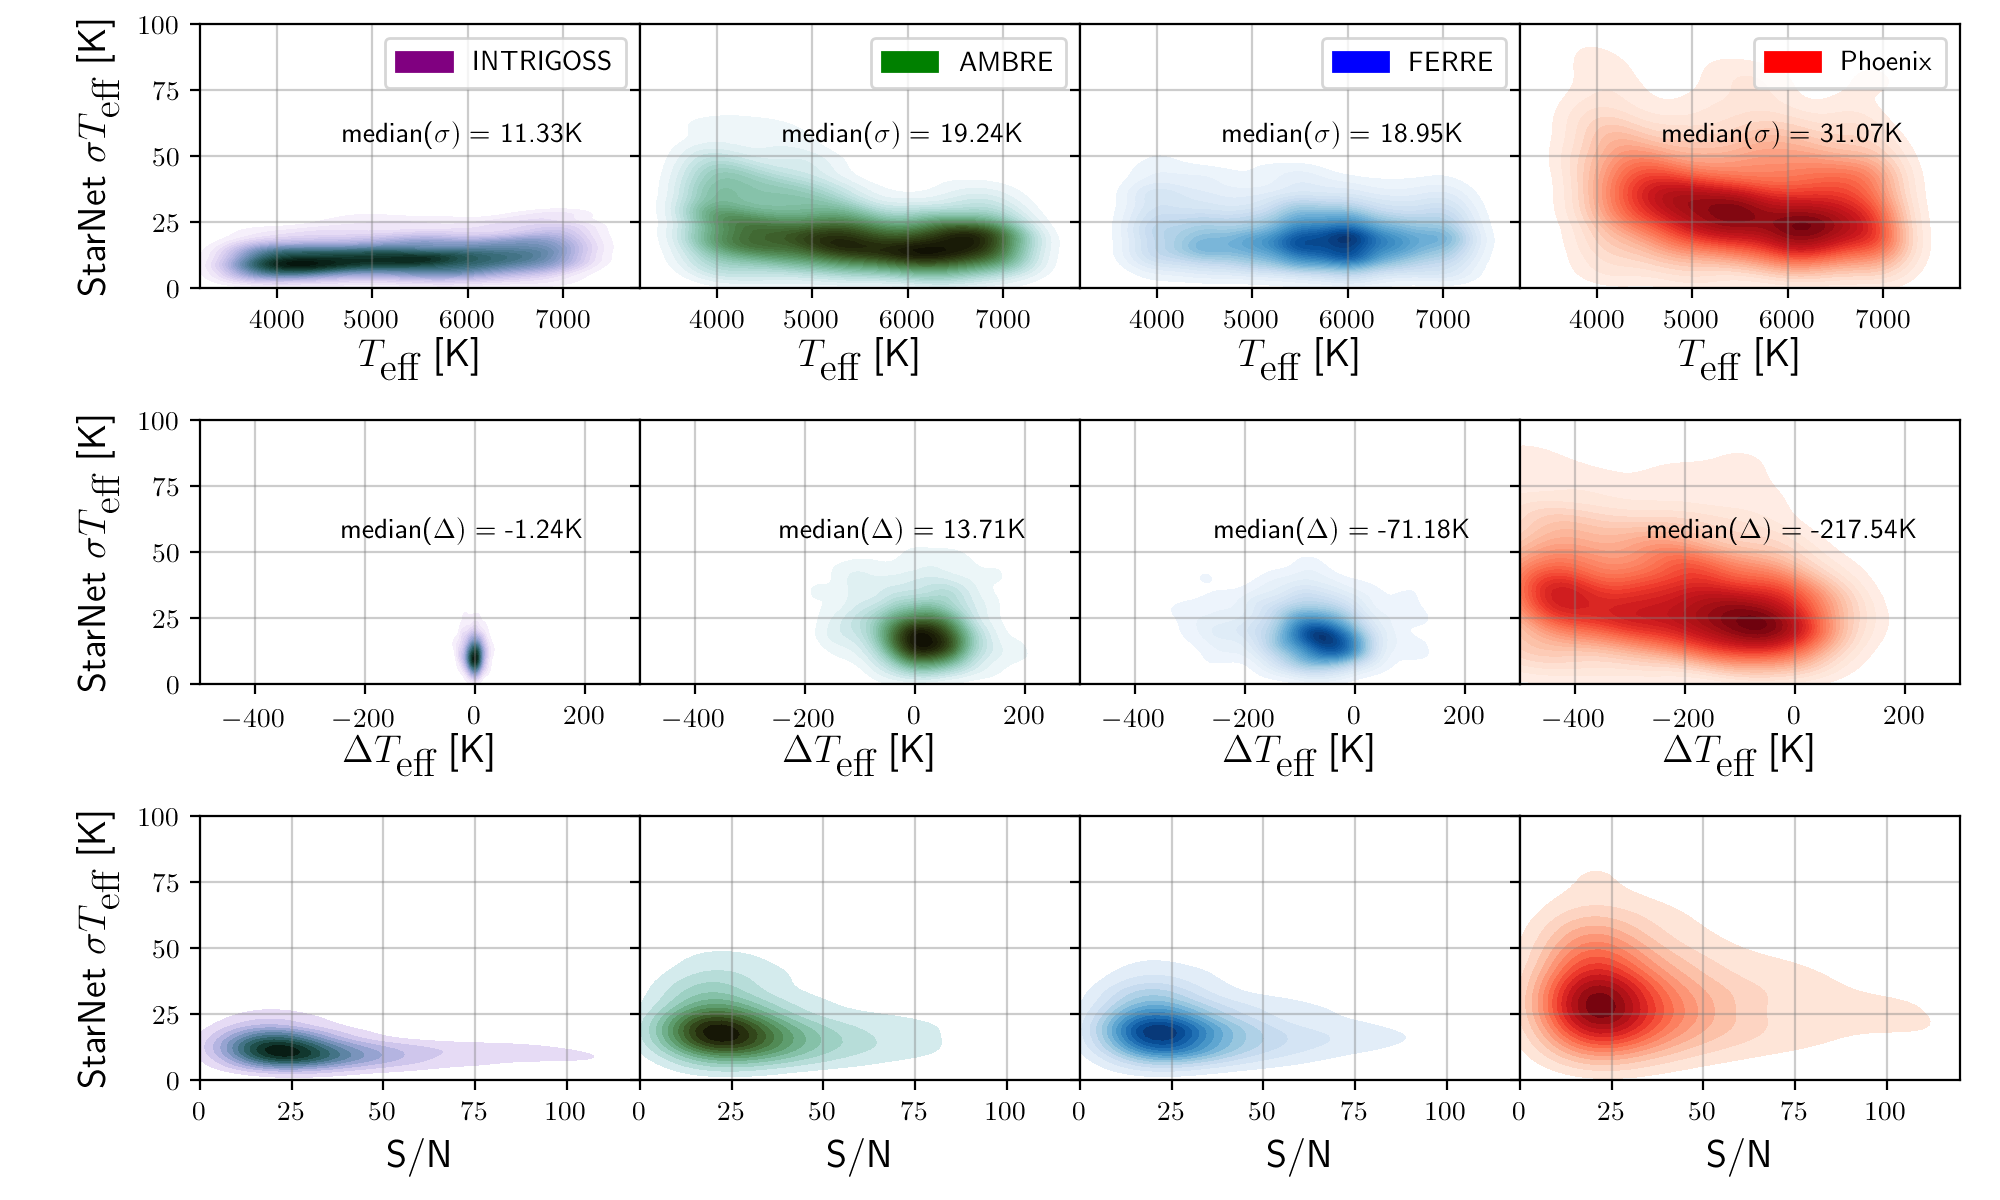

In [23]:
%matplotlib notebook
indices1 = (sigma_test_intri[:,0] < 150) & ((1./noise_synth_intri) < 200) & (sigma_test_intri[:,1] < 1.5) & \
           (sigma_test_intri[:,2] < 1.5) & (sigma_test_intri[:,5] < 4) & (sigma_test_intri[:,4] < 5.5)
indices2 = (sigma_test_ambre[:,0] < 150) & ((1./noise_synth_ambre) < 200) & (sigma_test_ambre[:,1] < 1.5) & \
           (sigma_test_ambre[:,2] < 1.5) & (sigma_test_ambre[:,5] < 4) & (sigma_test_ambre[:,4] < 5.5)
indices3 = (sigma_test_ferre[:,0] < 150) & ((1./noise_synth_ferre) < 200) & (sigma_test_ferre[:,1] < 1.5) & \
           (sigma_test_ferre[:,2] < 1.5) & (sigma_test_ferre[:,5] < 4) & (sigma_test_ferre[:,4] < 5.5)
indices4 = (sigma_test_phoenix[:,0] < 150) & ((1./noise_synth_phoenix) < 200) & (sigma_test_phoenix[:,1] < 1.5) & \
           (sigma_test_phoenix[:,2] < 1.5) & (sigma_test_phoenix[:,5] < 4) & (sigma_test_phoenix[:,4] < 5.5)

median_sigma_teff_intri = np.median(sigma_test_intri[:,0][indices1])
median_sigma_teff_ambre = np.median(sigma_test_ambre[:,0][indices2])
median_sigma_teff_ferre = np.median(sigma_test_ferre[:,0][indices3])
median_sigma_teff_phoenix = np.median(sigma_test_phoenix[:,0][indices4])
medians_sigma = [median_sigma_teff_intri, median_sigma_teff_ambre, median_sigma_teff_ferre, median_sigma_teff_phoenix]

median_delta_teff_intri = np.median(mu_test_intri[:,0][indices1] - y_synth_intri[:,0][indices1])
median_delta_teff_ambre = np.median(mu_test_ambre[:,0][indices2] - y_synth_ambre[:,0][indices2])
median_delta_teff_ferre = np.median(mu_test_ferre[:,0][indices3] - y_synth_ferre[:,0][indices3])
median_delta_teff_phoenix = np.median(mu_test_phoenix[:,0][indices4] - y_synth_phoenix[:,0][indices4])
medians_delta = [median_delta_teff_intri, median_delta_teff_ambre, median_delta_teff_ferre, median_delta_teff_phoenix]

cmap1 = sns.cubehelix_palette(12, start=2.10, as_cmap=True, dark=0.05, light=1, reverse=False)
cmap2 = sns.cubehelix_palette(12, start=1.4, as_cmap=True, dark=0.05, light=1, reverse=False)

fig, axes = plt.subplots(3, 4, figsize=(10, 6), sharey=True)

################ 1st row of plots
sns.kdeplot(y_synth_intri[:,0][indices1], sigma_test_intri[:,0][indices1], shade=True, n_levels=30, 
            cmap=cmap1, label='INTRIGOSS', ax=axes[0][0], shade_lowest=False)
sns.kdeplot(y_synth_ambre[:,0][indices2], sigma_test_ambre[:,0][indices2], shade=True, n_levels=30, 
            cmap=cmap2, label='AMBRE', ax=axes[0][1], shade_lowest=False)
sns.kdeplot(y_synth_ferre[:,0][indices3], sigma_test_ferre[:,0][indices3], shade=True, n_levels=30, 
            cmap='Blues', label='Ferre', ax=axes[0][2], shade_lowest=False)
sns.kdeplot(y_synth_phoenix[:,0][indices4], sigma_test_phoenix[:,0][indices4], shade=True, n_levels=30, 
            cmap="Reds", label='Phoenix', ax=axes[0][3], shade_lowest=False)
axes[0][0].set_ylabel(r'StarNet $\sigma T_{\textrm{eff}}$ [K]', size=14)
for i in range(len(medians_delta)):
    axes[0][i].set_ylim((0, 120))
    axes[0][i].set_xlim((3200, 7800))
    axes[0][i].set_xlabel(r'$T_{\textrm{eff}}$ [K]', size=14)
    axes[0][i].text(0.6, 0.58, r'median($\sigma) =$ {:.2f}K'.format(medians_sigma[i]), horizontalalignment='center',
                    verticalalignment='center', transform=axes[0][i].transAxes, size=10)

purple_patch = mpatches.Patch(color='purple', label='INTRIGOSS')
green_patch = mpatches.Patch(color='green', label='AMBRE')
blue_patch = mpatches.Patch(color='blue', label='FERRE')
red_patch = mpatches.Patch(color='red', label='Phoenix')
axes[0][0].legend(loc=0, fontsize=10, handles=[purple_patch])
axes[0][1].legend(loc=0, fontsize=10, handles=[green_patch])
axes[0][2].legend(loc=0, fontsize=10, handles=[blue_patch])
axes[0][3].legend(loc=0, fontsize=10, handles=[red_patch])

################ 2nd row of plots
sns.kdeplot(mu_test_intri[:,0][indices1] - y_synth_intri[:,0][indices1], sigma_test_intri[:,0][indices1], 
            shade=True, n_levels=30, cmap=cmap1, label='INTRIGOSS', ax=axes[1][0], shade_lowest=False)
sns.kdeplot(mu_test_ambre[:,0][indices2] - y_synth_ambre[:,0][indices2], sigma_test_ambre[:,0][indices2], 
            shade=True, n_levels=30, cmap=cmap2, label='AMBRE', ax=axes[1][1], shade_lowest=False)
sns.kdeplot(mu_test_ferre[:,0][indices3] - y_synth_ferre[:,0][indices3], sigma_test_ferre[:,0][indices3], 
            shade=True, n_levels=30, cmap="Blues", label='Ferre', ax=axes[1][2], shade_lowest=False)
sns.kdeplot(mu_test_phoenix[:,0][indices4] - y_synth_phoenix[:,0][indices4], sigma_test_phoenix[:,0][indices4], 
            shade=True, n_levels=30, cmap="Reds", label='Phoenix', ax=axes[1][3], shade_lowest=False)
axes[1][0].set_ylabel(r'StarNet $\sigma T_{\textrm{eff}}$ [K]', size=14)
for i in range(len(medians_delta)):
    axes[1][i].set_ylim((0, 100))
    axes[1][i].set_xlim((-500, 300))
    axes[1][i].set_xlabel(r'$\Delta T_{\textrm{eff}}$ [K]', size=14)
    axes[1][i].text(0.6, 0.58, r'median($\Delta) =$ {:.2f}K'.format(medians_delta[i]), horizontalalignment='center',
                    verticalalignment='center', transform=axes[1][i].transAxes, size=10)

################ 3rd row of plots
sns.kdeplot((1./noise_synth_intri)[indices1], sigma_test_intri[:,0][indices1], shade=True, n_levels=15, 
            cmap=cmap1, label='INTRIGOSS', ax=axes[2][0], shade_lowest=False, legend=False)
sns.kdeplot((1./noise_synth_ambre)[indices2], sigma_test_ambre[:,0][indices2], shade=True, n_levels=15, 
            cmap=cmap2, label='AMBRE', ax=axes[2][1], shade_lowest=False, legend=False)
sns.kdeplot((1./noise_synth_ferre)[indices3], sigma_test_ferre[:,0][indices3], shade=True, n_levels=15, 
            cmap="Blues", label='Ferre', ax=axes[2][2], shade_lowest=False, legend=False)
sns.kdeplot((1./noise_synth_phoenix)[indices4], sigma_test_phoenix[:,0][indices4], shade=True, n_levels=15, 
            cmap="Reds", label='Phoenix', ax=axes[2][3], shade_lowest=False, legend=False)
axes[2][0].set_ylabel(r'StarNet $\sigma T_{\textrm{eff}}$ [K]', size=14)
for i in range(len(medians_delta)):
    axes[2][i].set_ylim((0, 100))
    axes[2][i].set_xlim((0, 120))
    axes[2][i].set_xlabel(r'S/N', size=14)

#fig.legend((purple_patch, green_patch, red_patch), ('MRG', 'MRD', 'MP'), (0.28, 0.9), ncol=3, fontsize=13)
#plt.tight_layout()
left  = 0.1  # the left side of the subplots of the figure
right = 0.98    # the right side of the subplots of the figure
bottom = 0.10   # the bottom of the subplots of the figure
top = 0.98      # the top of the subplots of the figure
wspace = 0.0   # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

## Now to test the uncertainties on the full Phoenix dataset to see how the uncertainties behave beyond the limits of the INTRIGOSS grid

/home/merileo/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


<IPython.core.display.Javascript object>


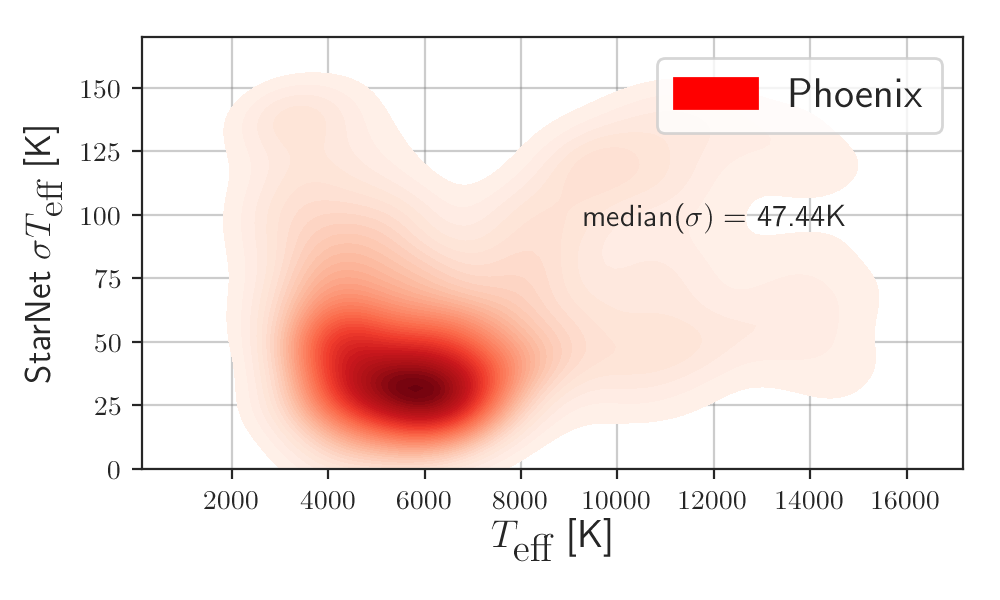

In [26]:
%matplotlib notebook
indices_full = (sigma_test_phoenix_full[:,0] < 150) & ((1./noise_synth_phoenix_full) < 200)# & (sigma_test_phoenix_full[:,1] < 1.5) & \
           #(sigma_test_phoenix_full[:,2] < 1.5) & (sigma_test_phoenix_full[:,5] < 4) & (sigma_test_phoenix_full[:,4] < 5.5)

median_sigma_teff_phoenix_full = np.median(sigma_test_phoenix_full[:,0][indices_full])

fig, axes = plt.subplots(1, figsize=(5, 3))
sns.kdeplot(y_synth_phoenix_full[:,0][indices_full], sigma_test_phoenix_full[:,0][indices_full], shade=True, n_levels=50, 
            cmap='Reds', label='Phoenix', ax=axes, shade_lowest=False, legend=True)
axes.set_ylim((0, 170))
#axes.set_xlim((2000, 8000))
axes.set_xlabel(r'$T_{\textrm{eff}}$ [K]', size=14)
axes.set_ylabel(r'StarNet $\sigma T_{\textrm{eff}}$ [K]', size=13)
axes.text(0.7, 0.58, r'median($\sigma) =$ {:.2f}K'.format(median_sigma_teff_phoenix_full), horizontalalignment='center',
          verticalalignment='center', transform=axes.transAxes, size=11)
red_patch = mpatches.Patch(color='red', label='Phoenix')
axes.legend(loc=0, fontsize=15, handles=[red_patch])
plt.tight_layout()

## Now to test on the INTRIGOSS spectra at intramesh positions to see how well our model can interpolate

In [62]:
# Predict on synthetic spectra
mu_test_off_grid, sigma_test_off_grid = ensemble_predict(off_grid_X, ensemble=ensemble, mu_labels=mu_labels, 
                                                         sigma_labels=sigma_labels)

Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained models...
Done! You now have the final predictions with uncertainties.


<IPython.core.display.Javascript object>


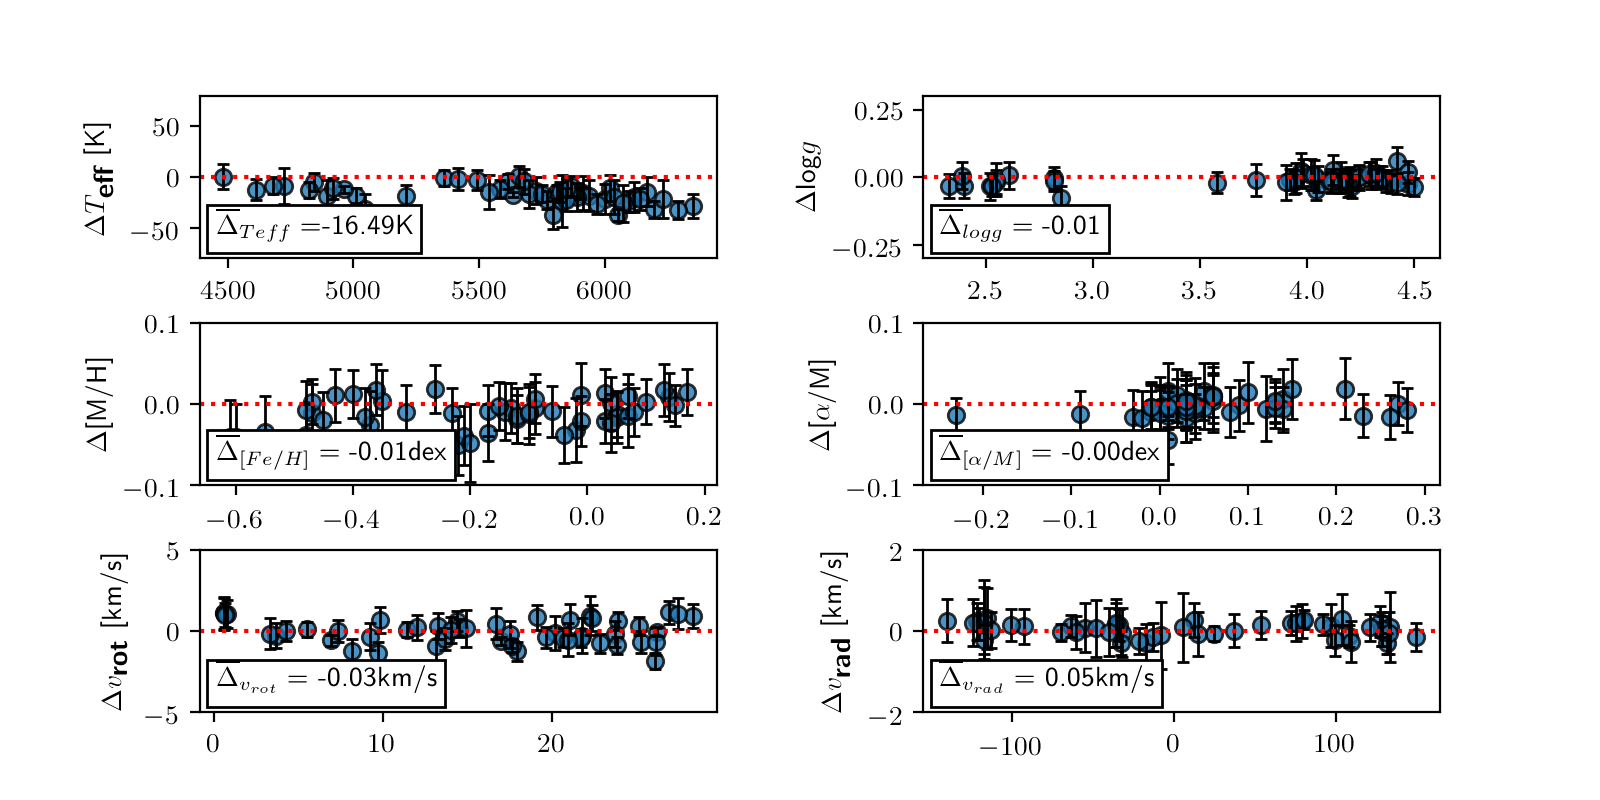

In [63]:
%matplotlib notebook
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1)
cm = plt.cm.get_cmap('RdYlBu')
fig = plt.figure(figsize=(8, 4)) 
gs = gridspec.GridSpec(3, 2,  width_ratios=[1, 1])

all_targets = np.asarray(off_grid_y)[:, [0,1,2,3,5,6]]
all_pred = np.asarray(mu_test_off_grid)[:]
difference = all_pred-all_targets
dy = sigma_test_off_grid

# Calculate statistics for the predictions
average_quadratic_diff_teff = np.nanmean(difference[:,0])
average_quadratic_diff_logg = np.nanmean(difference[:,1])
average_quadratic_diff_feh = np.nanmean(difference[:,2])
average_quadratic_diff_alpha = np.nanmean(difference[:,3])
average_quadratic_diff_vrot = np.nanmean(difference[:,4])
average_quadratic_diff_vrad = np.nanmean(difference[:,5])

aqd = [average_quadratic_diff_teff, average_quadratic_diff_logg, average_quadratic_diff_feh,
      average_quadratic_diff_alpha, average_quadratic_diff_vrot, average_quadratic_diff_vrad]

label_names = [r'$T_{\textbf{eff}}$ [K]', r'log$g$', r'[M/H]', r'[$\alpha$/M]',
               r'$v_{\textbf{rot}}$ [km/s]', r'$v_\textbf{{rad}}$ [km/s]', r'$v_\textbf{{micro}}$']
annots = [r'$\overline{{\Delta}}_{{Teff}}', r'$\overline{{\Delta}}_{{logg}}', r'$\overline{{\Delta}}_{{[Fe/H]}}',
         r'$\overline{{\Delta}}_{{[\alpha/M]}}', r'$\overline{{\Delta}}_{{v_{{rot}}}}', 
          r'$\overline{{\Delta}}_{{v_{{rad}}}}']
units = ['K', '', 'dex', 'dex', 'km/s', 'km/s']
ylims = [(-80,80), (-0.3,0.3), (-0.1,0.1), (-0.1,0.1), (-5, 5), (-2, 2)]

for i in range(np.shape(all_targets)[1]):
    
    if i < 2:
        ax = plt.subplot(gs[0,i])
    elif i < 4:
        ax = plt.subplot(gs[1,i%2])
    elif i < 6:
        ax = plt.subplot(gs[2,i%2])
    sc = plt.scatter(all_targets[:,i], difference[:,i], s=35,
                    cmap="BuPu", alpha=0.8, edgecolors="black", linewidth=1)
    sc1 = plt.errorbar(all_targets[:,i], difference[:,i], yerr=dy[:,i], linestyle='None', capsize=2, elinewidth=1, ecolor='black')
    annotation = annots[i] + '= ${:6.2f}{}'.format(aqd[i], units[i], width=6)
    ax.annotate(annotation, xy=(0.03, 0.12), xycoords='axes fraction', fontsize=10, bbox=bbox_props)
    plt.grid()
    plt.axhline(y=0, color='r', linestyle=':')
    plt.ylim(ylims[i])
    plt.ylabel(r'$\Delta$' + label_names[i], size=10)


fig.subplots_adjust(wspace=.4, hspace=0.4)
#plt.savefig('tests_intrigoss_intramesh.svg', transparent=True, format='svg')

## Load UVES dataset

In [6]:
#file_name = 'UVES_GE_MW_4835-5395_final.h5' #'UVES_GE_MW_4835-5395_updated.h5' #'UVES_GE_MW_4835-5395.h5' #'UVES_GE_MW_5840-6800.h5'
#file_name = 'UVES_GE_MW_4835-5395_final_werrors.h5'
file_name = 'UVES_GE_MW_4835-5395_final_werrors_wgaussian.h5'
#file_name = 'UVES_GE_MW_4835-5395_csigma.h5'
with h5py.File(os.path.join(preprocessed_spectra_path, file_name), "r") as f:
        print(list(f.keys()))
        X_uves = f['spectra_gaussiannorm'][:]
        spectra = f['spectra'][:]
        y_uves = np.column_stack([f['teff'][:], f['logg'][:], f['fe_h'][:], f['v_rad'][:], f['vmicro'][:]])
        y_uves_err = np.column_stack([f['teff_err'][:], f['logg_err'][:], f['fe_h_err'][:], 
                                      f['v_rad_err'][:], f['vmicro_err'][:]])
        snr_uves = f['SNR'][:]
        qual = f['qual'][:]
        ges_type = f['ges_type'][:]
        objects = f['object'][:]
        err_spectra = f['error_spectra'][:]
        wave_grid = f['wave_grid'][:]
        
non_nan_indices = np.array([not any(np.isnan(y)) for y in y_uves])
spectra = spectra[non_nan_indices]
X_uves = X_uves[non_nan_indices]
y_uves = y_uves[non_nan_indices]
y_uves_err = y_uves_err[non_nan_indices]
snr_uves = snr_uves[non_nan_indices]
ges_type = ges_type[non_nan_indices]
objects = objects[non_nan_indices]
qual = qual[non_nan_indices]
err_spectra = err_spectra[non_nan_indices]

# Take care of bad values
for i, spec in enumerate(X_uves):
    spec[qual[i]==1]=0
    spec[spec>1.03]=0
    spec[spec<0]=0
    
# Mask telluric lines
X_uves = mask_tellurics(os.path.join(starnet_data_folder, 'telluric_lines.txt'), X_uves, wave_grid)

['SNR', 'error_spectra', 'fe_h', 'fe_h_err', 'ges_type', 'logg', 'logg_err', 'object', 'qual', 'spectra', 'spectra_gaussiannorm', 'spectra_starnetnorm', 'teff', 'teff_err', 'v_rad', 'v_rad_err', 'vmicro', 'vmicro_err', 'wave_grid']


In [7]:
X_uves_highSNR = []
y_uves_highSNR = []
snr_uves_highSNR = []
ges_type_highSNR = []
objects_highSNR = []
qual_highSNR = []
for obj in np.unique(objects):
    indices = objects == obj
    temp_objs = objects[indices]
    if len(temp_objs) > 1:
        snr = snr_uves[indices]
        max_snr = max(snr)
        max_snr_index = snr_uves == max_snr
        X_uves_highSNR.append(X_uves[indices & max_snr_index])
        y_uves_highSNR.append(y_uves[indices & max_snr_index])
        snr_uves_highSNR.append(snr_uves[indices & max_snr_index])
        ges_type_highSNR.append(ges_type[indices & max_snr_index])
        objects_highSNR.append(objects[indices & max_snr_index])
        qual_highSNR.append(qual[indices & max_snr_index])
    else:
        X_uves_highSNR.append(X_uves[indices])
        y_uves_highSNR.append(y_uves[indices])
        snr_uves_highSNR.append(snr_uves[indices])
        ges_type_highSNR.append(ges_type[indices])
        objects_highSNR.append(objects[indices])
        qual_highSNR.append(qual[indices])
        
X_uves_highSNR = np.asarray(X_uves_highSNR).reshape(np.shape(X_uves_highSNR)[0], np.shape(X_uves_highSNR)[2], 1)
y_uves_highSNR = np.asarray(y_uves_highSNR).reshape(np.shape(y_uves_highSNR)[0], np.shape(y_uves_highSNR)[2])
snr_uves_highSNR = np.asarray(snr_uves_highSNR).reshape(len(snr_uves_highSNR))
ges_type_highSNR = np.asarray(ges_type_highSNR).reshape(len(ges_type_highSNR))
objects_highSNR = np.asarray(objects_highSNR).reshape(len(objects_highSNR))
qual_highSNR = np.asarray(qual_highSNR)

# Quality control using calibration clusters

### Predicting on UVES dataset...

In [8]:
mu_uves_highSNR, sigma_uves_highSNR = ensemble_predict(X_uves_highSNR, ensemble=ensemble, mu_labels=mu_labels,
                                                       sigma_labels=sigma_labels)

Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained models...
Done! You now have the final predictions with uncertainties.


In [9]:
# Predict on UVES spectra
mu_uves, sigma_uves = ensemble_predict(X_uves, ensemble=ensemble, mu_labels=mu_labels, sigma_labels=sigma_labels)

Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained models...
Done! You now have the final predictions with uncertainties.


In [11]:
NGC104_path = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/flames-uves/NGC104')
NGC2808_path = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/flames-uves/NGC2808')
NGC5927_path = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/flames-uves/NGC5927')
M67_path = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/flames-uves/M67')

NGC104_fits = glob.glob(os.path.join(NGC104_path, '*.fits'))
NGC2808_fits = glob.glob(os.path.join(NGC2808_path, '*.fits'))
NGC5927_fits = glob.glob(os.path.join(NGC5927_path, '*.fits'))
M67_fits = glob.glob(os.path.join(M67_path, '*.fits'))

GC_fits = [NGC104_fits, NGC2808_fits, NGC5927_fits, M67_fits]

In [12]:
# Wavelengths for masking beginning and end of spectrum
wave_min_mask = 4835
wave_max_mask = 5395

preds = [[], [], [], []]
sigmas = [[], [], [], []]

fluxes_norm = []
fluxes_nonorm = []
conts = []

for i in range(len(GC_fits)):
    for j in range(len(GC_fits[i])):
        with pyfits.open(GC_fits[i][j], memmap=False) as hdulist_spec:
            instrument = hdulist_spec[0].header['INSTRUME']
            ges = hdulist_spec[0].header['GES_TYPE']
            wl_min = hdulist_spec[0].header['WAVELMIN']
            wl_max = hdulist_spec[0].header['WAVELMAX']
            snr = hdulist_spec[0].header['SNR']
            obj = hdulist_spec[0].header['OBJECT']
            wav = hdulist_spec[1].data['WAVE'][0]
            flux = hdulist_spec[1].data['FLUX'][0]
            err = hdulist_spec[1].data['ERR'][0]
            qual = hdulist_spec[1].data['QUAL'][0]
            wav = wav * 10  # Convert to Angstroms

            mask = (wav > wave_min_mask) & (wav < wave_max_mask)
            flux = flux[mask]
            err = err[mask]
            wav = wav[mask]
            qual = qual[mask]
            
            fluxes_nonorm.append(flux)

            # Continuum normalize the spectrum
            flux, cont = continuum_normalize(flux, wav, fit='gaussian_smooth')#LINE_REGIONS, wav, SEGMENTS_STEP)
            
            conts.append(cont)
            fluxes_norm.append(flux)

            # Mask bad lines
            telluric_filename = 'telluric_lines.txt'
            telluric_file = os.path.join(starnet_data_folder, telluric_filename)
            flux = mask_tellurics(telluric_file, flux, wav)

            flux[flux>1.03]=0
            flux[flux<0]=0

            # Reshape data for compatibility with neural network
            X = np.reshape(flux, (np.shape(np.atleast_2d(flux))[0], np.shape(np.atleast_2d(flux))[1], 1))

            # Predict on spectra
            mu, sigma = ensemble_predict(X, ensemble=ensemble, mu_labels=mu_labels, sigma_labels=sigma_labels)
            
            preds[i].append(mu)
            sigmas[i].append(sigma)

/home/merileo/py36/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:165: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/home/merileo/py36/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:166: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained models...
Done! You now have the final predictions with uncertainties.
Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained models...
Done! You now have the final predictions with uncertainties.
Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained models...
Done! You now have the final predictions with uncertainties.
Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained models...
Done! You now have the final predictions with uncertainties.
Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained models...
Done! You now have the final predictions with uncertainties.
Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained models...
Done! You now have the final predictions with uncertainties.
Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained 

In [13]:
NGC104_pred, NGC104_sigma = np.asarray(preds[0]), np.asarray(sigmas[0])
NGC2808_pred, NGC2808_sigma = np.asarray(preds[1]), np.asarray(sigmas[1])
NGC5927_pred, NGC5927_sigma = np.asarray(preds[2]), np.asarray(sigmas[2])
M67_pred, M67_sigma = np.asarray(preds[3]), np.asarray(sigmas[3])

# Values retrieved from: 
# Globular clusters --> https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3query.pl
# Open clusters --> https://webda.physics.muni.cz/dist_list.html
NGC104_feh, NGC104_ageGyr = -0.67, 12
NGC2808_feh, NGC2808_ageGyr = -1.14, 12
NGC5927_feh, NGC5927_ageGyr = -0.49, 11
NGC1851_feh, NGC1851_ageGyr = -1.18, 11
M67_feh, M67_ageGyr = 0.0, 4
NGC3532_feh, NGC3532_ageGyr = -0.02, 0.310

In [14]:
gc_calibrators = ges_type == b'GE_SD_GC'
oc_calibrators = ges_type == b'GE_SD_OC'

# Load calibration globular cluster data
obj_globularclusters = objects[gc_calibrators]
order = np.argsort(obj_globularclusters)
X_uves_globularclusters = np.asarray(X_uves[gc_calibrators][order])
y_uves_globularclusters = np.asarray(y_uves[gc_calibrators][order])
y_uves_err_globularclusters = np.asarray(y_uves_err[gc_calibrators][order])
obj_globularclusters = np.asarray(obj_globularclusters[order])

# Load calibration open cluster data
obj_openclusters = objects[oc_calibrators]
order = np.argsort(obj_openclusters)
X_uves_openclusters = np.asarray(X_uves[oc_calibrators][order])
y_uves_openclusters = np.asarray(y_uves[oc_calibrators][order])
y_uves_err_openclusters = np.asarray(y_uves_err[oc_calibrators][order])
obj_openclusters = np.asarray(obj_openclusters[order])

In [15]:
X_uves_NGC104, y_uves_NGC104, y_uves_err_NGC104 = X_uves_globularclusters[:5], \
                                                  y_uves_globularclusters[:5], \
                                                  y_uves_err_globularclusters[:5]
X_uves_NGC1851, y_uves_NGC1851, y_uves_err_NGC1851 = X_uves_globularclusters[8:13], \
                                                     y_uves_globularclusters[8:13], \
                                                     y_uves_err_globularclusters[8:13]
X_uves_NGC2808, y_uves_NGC2808, y_uves_err_NGC2808 = X_uves_globularclusters[18:20], \
                                                     y_uves_globularclusters[18:20], \
                                                     y_uves_err_globularclusters[18:20]
X_uves_NGC3532, y_uves_NGC3532, y_uves_err_NGC3532 = X_uves_openclusters, y_uves_openclusters, \
                                                     y_uves_err_openclusters
mu_NGC104, sigma_NGC104 = ensemble_predict(X_uves_NGC104, ensemble=ensemble, mu_labels=mu_labels, 
                                           sigma_labels=sigma_labels)
mu_NGC1851, sigma_NGC1851 = ensemble_predict(X_uves_NGC1851, ensemble=ensemble, mu_labels=mu_labels, 
                                             sigma_labels=sigma_labels)
mu_NGC2808, sigma_NGC2808 = ensemble_predict(X_uves_NGC2808, ensemble=ensemble, mu_labels=mu_labels, 
                                             sigma_labels=sigma_labels)  
mu_NGC3532, sigma_NGC3532 = ensemble_predict(X_uves_NGC3532, ensemble=ensemble, mu_labels=mu_labels, 
                                             sigma_labels=sigma_labels)

mu_NGC104, sigma_NGC104 = np.asarray(mu_NGC104), np.asarray(sigma_NGC104)
mu_NGC1851, sigma_NGC1851 = np.asarray(mu_NGC1851), np.asarray(sigma_NGC1851)
mu_NGC2808, sigma_NGC2808 = np.asarray(mu_NGC2808), np.asarray(sigma_NGC2808)
mu_NGC3532, sigma_NGC3532 = np.asarray(mu_NGC3532), np.asarray(sigma_NGC3532)

Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained models...
Done! You now have the final predictions with uncertainties.
Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained models...
Done! You now have the final predictions with uncertainties.
Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained models...
Done! You now have the final predictions with uncertainties.
Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained models...
Done! You now have the final predictions with uncertainties.


### Metallicity consistency check for StarNet predictions of the calibration clusters

<IPython.core.display.Javascript object>


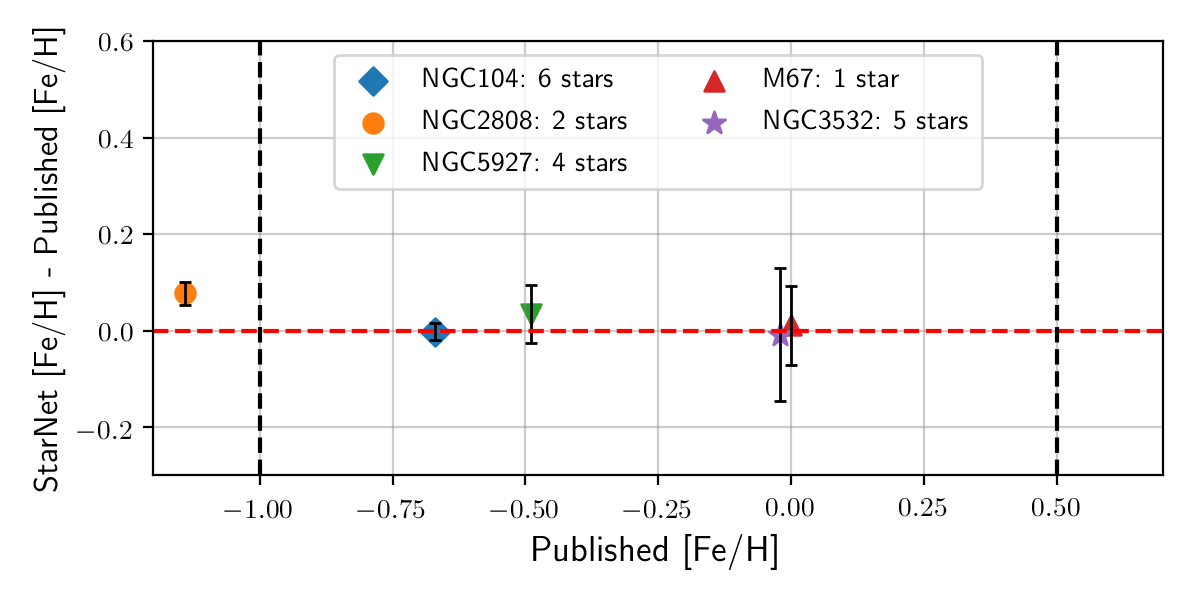

In [16]:
%matplotlib notebook
plt.figure(figsize=(6,3))
x_NGC104, x_NGC2808, x_NGC5927, x_M67, x_NGC1851, x_NGC3532 = NGC104_feh, NGC2808_feh, \
                                                              NGC5927_feh, M67_feh, NGC1851_feh, NGC3532_feh
y_NGC104, y_NGC2808, y_NGC5927, y_M67, y_NGC1851, y_NGC3532 = \
                                            np.mean(mu_NGC104[:,2] - NGC104_feh), \
                                            np.mean(NGC2808_pred[:,2] - NGC2808_feh), \
                                            np.mean(NGC5927_pred[:,2] - NGC5927_feh), \
                                            M67_pred[:,2] - M67_feh, \
                                            np.mean(mu_NGC1851[:,2] - NGC1851_feh), \
                                            np.mean(mu_NGC3532[:,2] - NGC3532_feh)
dy_NGC104, dy_NGC2808, dy_NGC5927, dy_M67, dy_NGC1851, dy_NGC3532 = \
                                            np.std(mu_NGC104[:,2] - NGC104_feh), \
                                            np.std(NGC2808_pred[:,2] - NGC2808_feh), \
                                            np.std(NGC5927_pred[:,2] - NGC5927_feh), \
                                            np.asarray(M67_sigma)[:,2], \
                                            np.std(mu_NGC1851[:,2] - NGC1851_feh), \
                                            np.std(mu_NGC3532[:,2] - NGC3532_feh)

plt.scatter(x_NGC104, y_NGC104, label='NGC104: {} stars'.format(len(NGC104_pred)), marker='D', s=50)
plt.errorbar(x_NGC104, y_NGC104, yerr=dy_NGC104, linestyle='None', capsize=2, elinewidth=1, ecolor='black')

plt.scatter(x_NGC2808, y_NGC2808, label='NGC2808: {} stars'.format(len(NGC2808_pred)), marker='o', s=50)
plt.errorbar(x_NGC2808, y_NGC2808, yerr=dy_NGC2808, linestyle='None', capsize=2, elinewidth=1, ecolor='black')

plt.scatter(x_NGC5927, y_NGC5927, label='NGC5927: {} stars'.format(len(NGC5927_pred)), marker='v', s=50)
plt.errorbar(x_NGC5927, y_NGC5927, yerr=dy_NGC5927, linestyle='None', capsize=2, elinewidth=1, ecolor='black')

plt.scatter(x_M67, y_M67, label='M67: {} star'.format(len(M67_pred)), marker='^', s=50)
plt.errorbar(x_M67, y_M67, yerr=dy_M67, linestyle='None', capsize=2, elinewidth=1, ecolor='black')

plt.scatter(x_NGC3532, y_NGC3532, label='NGC3532: {} stars'.format(len(mu_NGC3532)), marker='*', s=70)
plt.errorbar(x_NGC3532, y_NGC3532, yerr=dy_NGC3532, linestyle='None', capsize=2, elinewidth=1, ecolor='black')

plt.legend(loc='upper center', fontsize=10, ncol=2)
plt.ylim(-0.3, 0.6)
plt.xlim(-1.2, 0.7)
plt.axhline(0.0, ls='--', color='red')
plt.axvline(-1.0, ls='--', color='black')
plt.axvline(0.5, ls='--', color='black')
plt.ylabel('StarNet [Fe/H] - Published [Fe/H]', size=12)
plt.xlabel('Published [Fe/H]', size=13)
plt.tight_layout()

### HR diagrams of the calibration clusters

<IPython.core.display.Javascript object>


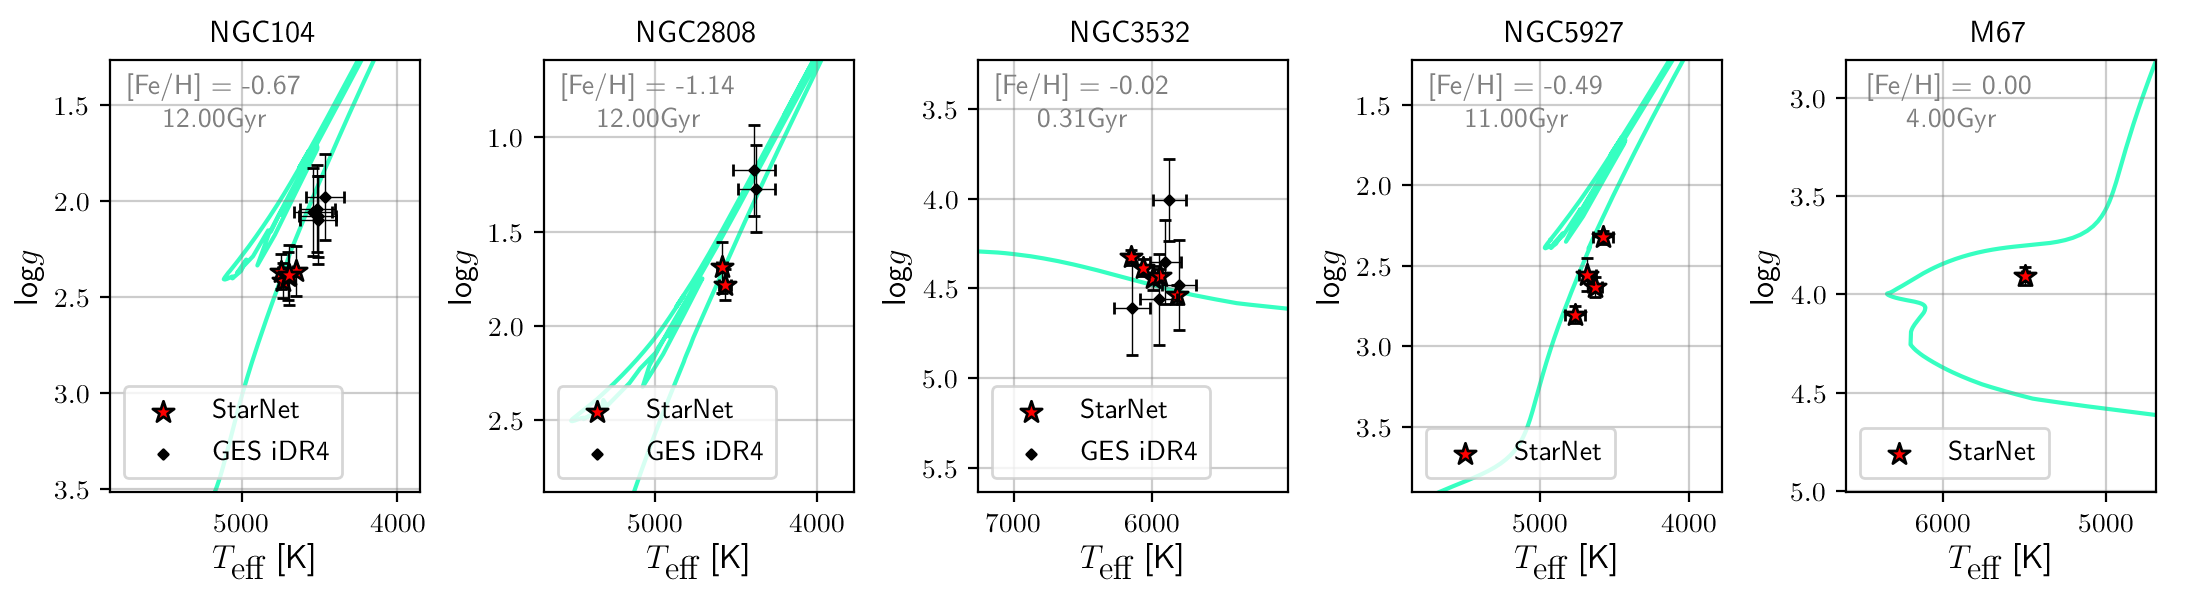

In [28]:
mist = MIST_Isochrone()
cmap = matplotlib.cm.get_cmap('jet')

feh = [NGC104_feh, NGC2808_feh, NGC3532_feh, NGC5927_feh, M67_feh]
ages = [NGC104_ageGyr, NGC2808_ageGyr, NGC3532_ageGyr, NGC5927_ageGyr, M67_ageGyr]

x_data_uves = [y_uves_NGC104[:,0], y_uves_NGC2808[:,0], y_uves_NGC3532[:,0]]
y_data_uves = [y_uves_NGC104[:,1], y_uves_NGC2808[:,1], y_uves_NGC3532[:,1]]
dx_uves = [y_uves_err_NGC104[:,0], y_uves_err_NGC2808[:,0], y_uves_err_NGC3532[:,0]]
dy_uves = [y_uves_err_NGC104[:,1], y_uves_err_NGC2808[:,1], y_uves_err_NGC3532[:,1]]

x_data_starnet = [mu_NGC104[:,0], mu_NGC2808[:,0], mu_NGC3532[:,0], NGC5927_pred[:,0], M67_pred[:,0]]
y_data_starnet = [mu_NGC104[:,1], mu_NGC2808[:,1], mu_NGC3532[:,1], NGC5927_pred[:,1], M67_pred[:,1]]
dx_starnet = [sigma_NGC104[:,0], sigma_NGC2808[:,0], sigma_NGC3532[:,0], NGC5927_sigma[:,0], M67_sigma[:,0]]
dy_starnet = [sigma_NGC104[:,1], sigma_NGC2808[:,1], sigma_NGC3532[:,1], NGC5927_sigma[:,1], M67_sigma[:,1]]

titles = ['NGC104', 'NGC2808', 'NGC3532', 'NGC5927', 'M67']

fig, axes = plt.subplots(1, len(x_data_starnet), figsize=(11, 3))

for i in range(len(x_data_starnet)):
    
    # Plot isochrone
    iso = mist.isochrone(np.log10(ages[i] * 1e9), feh[i])
    norm = matplotlib.colors.Normalize(vmin=-1.5, vmax=0.5)
    axes[i].plot(iso['Teff'][:700], iso['logg'][:700], c=cmap(norm(NGC104_feh)), zorder=1)
    
    # Plot StarNet predictions
    axes[i].errorbar(x_data_starnet[i], y_data_starnet[i], yerr=dy_starnet[i],
                     xerr=dx_starnet[i], linestyle='None', capsize=2, elinewidth=0.5, 
                     ecolor='black', zorder=10)
    l1 = axes[i].scatter(x_data_starnet[i], y_data_starnet[i], c='red', marker='*', 
                         label='StarNet', zorder=11, s=65, edgecolor='black', linewidth='1')
    
    # Plot GES iDR4 parameters (if available)
    if i < 3:
        axes[i].errorbar(x_data_uves[i], y_data_uves[i], yerr=dy_uves[i], 
                         xerr=dx_uves[i], linestyle='None', capsize=2, elinewidth=0.5, 
                         ecolor='black', zorder=12)
        l2 = axes[i].scatter(x_data_uves[i], y_data_uves[i], c='black', marker='D', s=6, 
                             label='GES iDR4', zorder=13)
        
        axes[i].legend((l1, l2), ('StarNet', 'GES iDR4'), loc=3)
    else:
        axes[i].legend((l1,), ('StarNet',), loc=3)
        
    # Place text on figure displaying [Fe/H] and age of cluster
    axes[i].text(0.34, 0.90, '[Fe/H] = {:.2f} \n{:.2f}Gyr'.format(feh[i], ages[i]), 
                 horizontalalignment='center', verticalalignment='center', 
                 transform=axes[i].transAxes, size=10, color='grey')

    axes[i].invert_xaxis()
    axes[i].invert_yaxis()
    axes[i].set_xlabel(r'$T_{\textrm{eff}}$ [K]', size=12)
    axes[i].set_ylabel(r'log$g$', size=12)
    axes[i].set_xlim((max(x_data_starnet[i])+1100,min(x_data_starnet[i])-800))
    axes[i].set_ylim((max(y_data_starnet[i])+1.1,min(y_data_starnet[i])-1.1))
    axes[i].set_title(titles[i], size=11)
    
left  = 0.05  # the left side of the subplots of the figure
right = 0.98    # the right side of the subplots of the figure
bottom = 0.18   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


# Now to predict on the Gaia Benchmark Stars

- All spectra for the benchmark stars were downloaded from ftp://obsftp.unige.ch/pub/sblancoc/Gaia_Benchmark_Stars_Library/
- Temperatures and surface gravities from http://cdsads.u-strasbg.fr/abs/2015A&A...582A..49H
- Metallicities from http://cdsads.u-strasbg.fr/abs/2014A&A...564A.133J



In [21]:
benchmarks_path = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/flames-uves/benchmark-stars/')
ref_file = os.path.join(benchmarks_path, 'benchmark_stars_overview.txt')
ref = np.genfromtxt(ref_file, dtype=str, delimiter='\t')

In [22]:
df_full = pd.DataFrame(data=ref[1:,1:],    # values
             index=ref[1:,0],    # 1st column as index
             columns=ref[0,1:])  # 1st row as the column names

# Grab only spectra taken with UVES
df_uves_all = df_full[df_full['origin']=='BS_UVES']

# Some entries appear twice, so separate these
list_2 = [ID for ID in df_uves_all.ID if '-2' in ID] # All entries with a '-2' in the ID name
df_uves1 = df_uves_all[~df_uves_all['ID'].isin(list_2)].copy(deep=False)
df_uves2 = df_uves_all[df_uves_all['ID'].isin(list_2)].copy(deep=False)

# Convert everything from strings to numbers
df_uves1['Teff'] = df_uves1['Teff'].astype(int)
df_uves1['logg'] = df_uves1['logg'].astype(float)
df_uves1['[Fe/H]'] = df_uves1['[Fe/H]'].astype(float)
df_uves1['vsini'] = df_uves1['vsini'].astype(float)
df_uves1['[Ca/H]'] = df_uves1['[Ca/H]'].astype(float)
df_uves1['[Mg/H]'] = df_uves1['[Mg/H]'].astype(float)
df_uves1['[Si/H]'] = df_uves1['[Si/H]'].astype(float)
df_uves1['[Ti/H]'] = df_uves1['[Ti/H]'].astype(float)
df_uves2['Teff'] = df_uves2['Teff'].astype(int)
df_uves2['logg'] = df_uves2['logg'].astype(float)
df_uves2['[Fe/H]'] = df_uves2['[Fe/H]'].astype(float)
df_uves2['vsini'] = df_uves2['vsini'].astype(float)

df_uves1 = df_uves1.drop('alfTau')

In [23]:
df_uves1.keys()

Index(['ID', 'origin', 'snr', 'R', 'HIP_ID', 'Group', 'Teff', 'eTeff', 'logg',
       'elogg', 'vmic_GES', 'vmac_GES', 'vsini', 'e_vsini', '[Fe/H]',
       'e[Fe/H]', '[Ca/H]', 'e[Ca/H]', '[Co/H]', 'e[Co/H]', '[Cr/H]',
       'e[Cr/H]', '[Mg/H]', 'e[Mg/H]', '[Mn/H]', 'e[Mn/H]', '[Ni/H]',
       'e[Ni/H]', '[Sc/H]', 'e[Sc/H]', '[Si/H]', 'e[Si/H]', '[Ti/H]',
       'e[Ti/H]', '[V/H]', 'e[V/H]'],
      dtype='object')

In [24]:
# Define parameters needed for continuum normalization
wave_grid_uves = wave_grid
line_regions = [[4210, 4240], [4250, 4410], [4333, 4388], [4845, 4886], [5160, 5200], [5874, 5916], [6530, 6590]]
segments_step = 10. # divide the spectrum into segments of 10 Angstroms

## Get final predictions on benchmarks for chosen model

In [62]:
import importlib
#from starnet.utils.nn_utils.deep_ensemble import denormalize_mu, denormalize_sigma, get_model_training_info, \
#mad_based_outlier, load_ensemble, ensemble_predict
import starnet.utils.nn_utils.deep_ensemble
importlib.reload(starnet.utils.nn_utils.deep_ensemble)
from starnet.utils.nn_utils.deep_ensemble import ensemble_predict, load_ensemble

In [63]:
import warnings
warnings.filterwarnings("ignore")
telluric_filename = 'telluric_lines.txt'
telluric_file = os.path.join(starnet_data_folder, telluric_filename)
fluxes_norm = []
fluxes_nonorm = []
errors = []
continuums = []
starnet_teff = []
starnet_teff_uncertainty = []
starnet_logg = []
starnet_logg_uncertainty = []
starnet_feh = []
starnet_feh_uncertainty = []
starnet_alpha = []
starnet_alpha_uncertainty = []
starnet_vsini = []
starnet_vsini_uncertainty = []
df_uves = df_uves1

# Load the ensemble of models
ensemble, mu_labels, sigma_labels = load_ensemble(ensemble_path, maximum_loss_accepted=3.5, top_n=7)
for index, star in df_uves.iterrows():
    print(star['ID'])
    # Load .txt file containing wavelength and flux arrays
    x = np.loadtxt(benchmarks_path + '%s_47000.txt' % star['ID'], skiprows=1)
    wave, flux, err = x[:,0], x[:,1], x[:,2]
    wave*=10.  # Convert to angstroms

    # Rebin to UVES grid
    flux = rebin(wave_grid_uves, wave, flux)
    err = rebin(wave_grid_uves, wave, err)

    flux_nonorm = flux
    fluxes_nonorm.append(flux_nonorm)
    errors.append(err)
    
    # Continuum normalize the spectrum
    flux, cont = continuum_normalize(flux, line_regions, wave_grid_uves, 10)
    
    continuums.append(cont)
    fluxes_norm.append(flux)

    # Mask bad lines
    flux = mask_tellurics(telluric_file, flux, wave_grid)
    snr_threshold=80
    print('Number of bad points: {}'.format(sum((flux_nonorm/err)<snr_threshold)))
    #flux[(flux_nonorm/err)<snr_threshold]=0
    flux[flux>1.03]=0
    flux[flux<0]=0

    # Reshape data for compatibility with neural network
    X = np.reshape(flux, (np.shape(np.atleast_2d(flux))[0], np.shape(np.atleast_2d(flux))[1], 1))

    # Predict on spectra
    mu, sigma = ensemble_predict(X, ensemble=ensemble, mu_labels=mu_labels, sigma_labels=sigma_labels)
    
    starnet_teff.append(int(mu[0]))
    starnet_teff_uncertainty.append(sigma[0])
    starnet_logg.append(mu[1])
    starnet_logg_uncertainty.append(sigma[1])
    starnet_feh.append(mu[2])
    starnet_feh_uncertainty.append(sigma[2])
    starnet_alpha.append(mu[3])
    starnet_alpha_uncertainty.append(sigma[3])
    starnet_vsini.append(mu[4])
    starnet_vsini_uncertainty.append(mu[4])
    
df_uves['StarNet Teff'] = starnet_teff
df_uves['StarNet Teff unc.'] = starnet_teff_uncertainty
df_uves['StarNet logg'] = starnet_logg
df_uves['StarNet logg unc.'] = starnet_logg_uncertainty
df_uves['StarNet [Fe/H]'] = starnet_feh
df_uves['StarNet [Fe/H] unc.'] = starnet_feh_uncertainty
df_uves['StarNet [alpha/M]'] = starnet_alpha
df_uves['StarNet [alpha/M] unc.'] = starnet_alpha_uncertainty
df_uves['StarNet vsini'] = starnet_vsini
df_uves['StarNet vsini unc.'] = starnet_vsini_uncertainty

Loading model: model13
Loading model: model6
Loading model: model3
Loading model: model7
Loading model: model4
Loading model: model9
Loading model: model2
The ensemble contains 7 models with the following validation losses: 
(2.1654713780704244, 2.258289113308456, 2.3152191413618444, 2.3475384595859334, 2.3545059391660375, 2.357806587662741, 2.3608572271564316)
UVES_Arcturus-1
Number of bad points: 28
Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained models...
Done! You now have the final predictions with uncertainties.
UVES_HD102200
Number of bad points: 0
Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained models...
Done! You now have the final predictions with uncertainties.
UVES_HD106038
Number of bad points: 0
Using pre-loaded ensemble...
Predicting on the dataset with ensemble of 7 trained models...
Done! You now have the final predictions with uncertainties.
UVES_HD122563-1
Number of bad points: 0
Using pre-loaded ens

### In order to calculate statistics of the predictions, I follow the method outlined in R. Smiljanic et al. (2014, https://arxiv.org/pdf/1409.0568.pdf):

1. Split the stars into three groups, covering separate parts of parameter space:
    - **metal-rich dwarfs (MRD)**: [Fe/H] $\gt$ -1.00 and log*g* $\gt$ 3.5
    - **metal-rich giants (MRG)**: [Fe/H] $\gt$ -1.00 and log*g* $\leq$ 3.5
    - **metal-poor stars**: [Fe/H] $\leq$ -1.00 **NOTE:** INTRIGOSS doesn't go below -1.00 in [Fe/H], so these are not included in the analysis
    
2. Calculate the average quadratic difference between the reference and the derived atmospheric parameters of the stars. If this average quadratic difference is within ± 100 K and ± 0.20 dex of the reference values, the results are considered to be very accurate.


In [64]:
# Separate the MRDs from the MRGs from MPs
metal_rich = df_uves['[Fe/H]'] > -1.
metal_poor = df_uves['[Fe/H]'] <= -1.
dwarf = df_uves['logg'] > 3.5
giant = df_uves['logg'] <= 3.5
MRD = df_uves[metal_rich & dwarf]# & good_value]
MRG = df_uves[metal_rich & giant]# & good_value]
MP = df_uves[metal_poor]
#MRD_and_MRG = MRD.append(MRG)

# Drop Alpha Tau and Psi Phe because they have bad spectra!
try:
    MRG = MRG.drop('alfTau')
except:
    print('alfTau already gone')
try:
    MP = MP.drop('psiPhe')
except:
    print('psiPhe already gone')
# Drop very metal poor stars ([Fe/H] < -2)
MP = MP[MP['[Fe/H]'] > -2]

alfTau already gone


In [65]:
MRD[['[Fe/H]', 'StarNet [Fe/H]', 'StarNet [Fe/H] unc.', 
     'Teff', 'StarNet Teff', 'StarNet Teff unc.',
     'logg', 'StarNet logg', 'StarNet logg unc.',
     'snr', 'e_vsini']]

,[Fe/H],StarNet [Fe/H],StarNet [Fe/H] unc.,Teff,StarNet Teff,StarNet Teff unc.,logg,StarNet logg,StarNet logg unc.,snr,e_vsini
Procyon,-0.04,-0.070626,0.038954,6554,6464,15.408023,4.000,3.755758,0.048511,360.0,0.6
Sun,0.02,-0.010373,0.048878,5771,5753,9.765924,4.438,4.383048,0.068527,383.0,0.3
alfCenA,0.24,0.166482,0.043106,5792,5705,18.078449,4.310,4.197953,0.109962,316.0,0.6
betHyi,-0.07,-0.102772,0.040629,5873,5848,13.816320,3.980,3.907103,0.045212,419.0,0.3
delEri,0.06,0.092857,0.036258,4954,5073,7.660916,3.760,3.859191,0.117891,206.0,0.6
epsEri,-0.10,-0.163550,0.043515,5076,5060,23.715154,4.610,4.674156,0.056276,220.0,0.2
muAra,0.33,0.281153,0.037589,5902,5735,12.088073,4.300,4.185902,0.095491,309.0,0.8


In [66]:
MRG[['[Fe/H]', 'StarNet [Fe/H]', 'StarNet [Fe/H] unc.', 
     'Teff', 'StarNet Teff', 'StarNet Teff unc.',
     'logg', 'StarNet logg', 'StarNet logg unc.',
     'snr', 'vsini', 'e_vsini']]

,[Fe/H],StarNet [Fe/H],StarNet [Fe/H] unc.,Teff,StarNet Teff,StarNet Teff unc.,logg,StarNet logg,StarNet logg unc.,snr,vsini,e_vsini
Arcturus,-0.53,-0.639337,0.044149,4286,4403,24.045333,1.64,2.069948,0.165773,283.0,3.8,1.0
alfCet,-0.45,-0.530872,0.214818,3796,3887,96.285967,0.68,0.892633,0.378706,207.0,3.0,2.0
betGem,0.12,0.076397,0.038990,4858,4976,15.245052,2.90,3.119381,0.041101,163.0,2.0,1.0


In [67]:
MP[['[Fe/H]', 'StarNet [Fe/H]', 'StarNet [Fe/H] unc.', 
     'Teff', 'StarNet Teff', 'StarNet Teff unc.',
     'logg', 'StarNet logg', 'StarNet logg unc.',
     'snr', 'vsini', 'e_vsini']]

,[Fe/H],StarNet [Fe/H],StarNet [Fe/H] unc.,Teff,StarNet Teff,StarNet Teff unc.,logg,StarNet logg,StarNet logg unc.,snr,vsini,e_vsini
HD102200,-1.16,-1.145581,0.060668,6155,6134,24.853288,4.22,4.037865,0.171521,160.0,1.90,4.59
HD106038,-1.27,-1.185941,0.062587,6121,6092,29.838045,4.55,4.143414,0.169498,254.0,0.00,0.0
HD201891,-1.00,-1.008435,0.062569,5948,5988,7.193502,4.30,4.273037,0.110200,107.0,2.93,5.31
HD298986,-1.31,-1.221489,0.059668,6223,6226,25.008255,4.19,4.043382,0.181298,173.0,4.07,5.98


In [68]:
# Calculate statistics for the predictions
average_quadratic_diff_teff_MRD = np.nanmean(np.abs(MRD['Teff'] - MRD['StarNet Teff']))
average_quadratic_diff_logg_MRD = np.nanmean(np.abs(MRD['logg'] - MRD['StarNet logg']))
average_quadratic_diff_feh_MRD = np.nanmean(np.abs(MRD['[Fe/H]'] - MRD['StarNet [Fe/H]']))
average_quadratic_diff_vsini_MRD = np.nanmean(np.abs(MRD['vsini'] - MRD['StarNet vsini']))

average_quadratic_diff_teff_MRG = np.nanmean(np.abs(MRG['Teff'] - MRG['StarNet Teff']))
average_quadratic_diff_logg_MRG = np.nanmean(np.abs(MRG['logg'] - MRG['StarNet logg']))
average_quadratic_diff_feh_MRG = np.nanmean(np.abs(MRG['[Fe/H]'] - MRG['StarNet [Fe/H]']))
average_quadratic_diff_vsini_MRG = np.nanmean(np.abs(MRG['vsini'] - MRG['StarNet vsini']))

average_quadratic_diff_teff_MP = np.nanmean(np.abs(MP['Teff'] - MP['StarNet Teff']))
average_quadratic_diff_logg_MP = np.nanmean(np.abs(MP['logg'] - MP['StarNet logg']))
average_quadratic_diff_feh_MP = np.nanmean(np.abs(MP['[Fe/H]'] - MP['StarNet [Fe/H]']))
average_quadratic_diff_vsini_MP = np.nanmean(np.abs(MP['vsini'] - MP['StarNet vsini']))

aqd_MRD = [average_quadratic_diff_teff_MRD, average_quadratic_diff_logg_MRD, average_quadratic_diff_feh_MRD,
          average_quadratic_diff_vsini_MRD]

aqd_MRG = [average_quadratic_diff_teff_MRG, average_quadratic_diff_logg_MRG, average_quadratic_diff_feh_MRG,
          average_quadratic_diff_vsini_MRG]

aqd_MP = [average_quadratic_diff_teff_MP, average_quadratic_diff_logg_MP, average_quadratic_diff_feh_MP,
         average_quadratic_diff_vsini_MP]

<IPython.core.display.Javascript object>


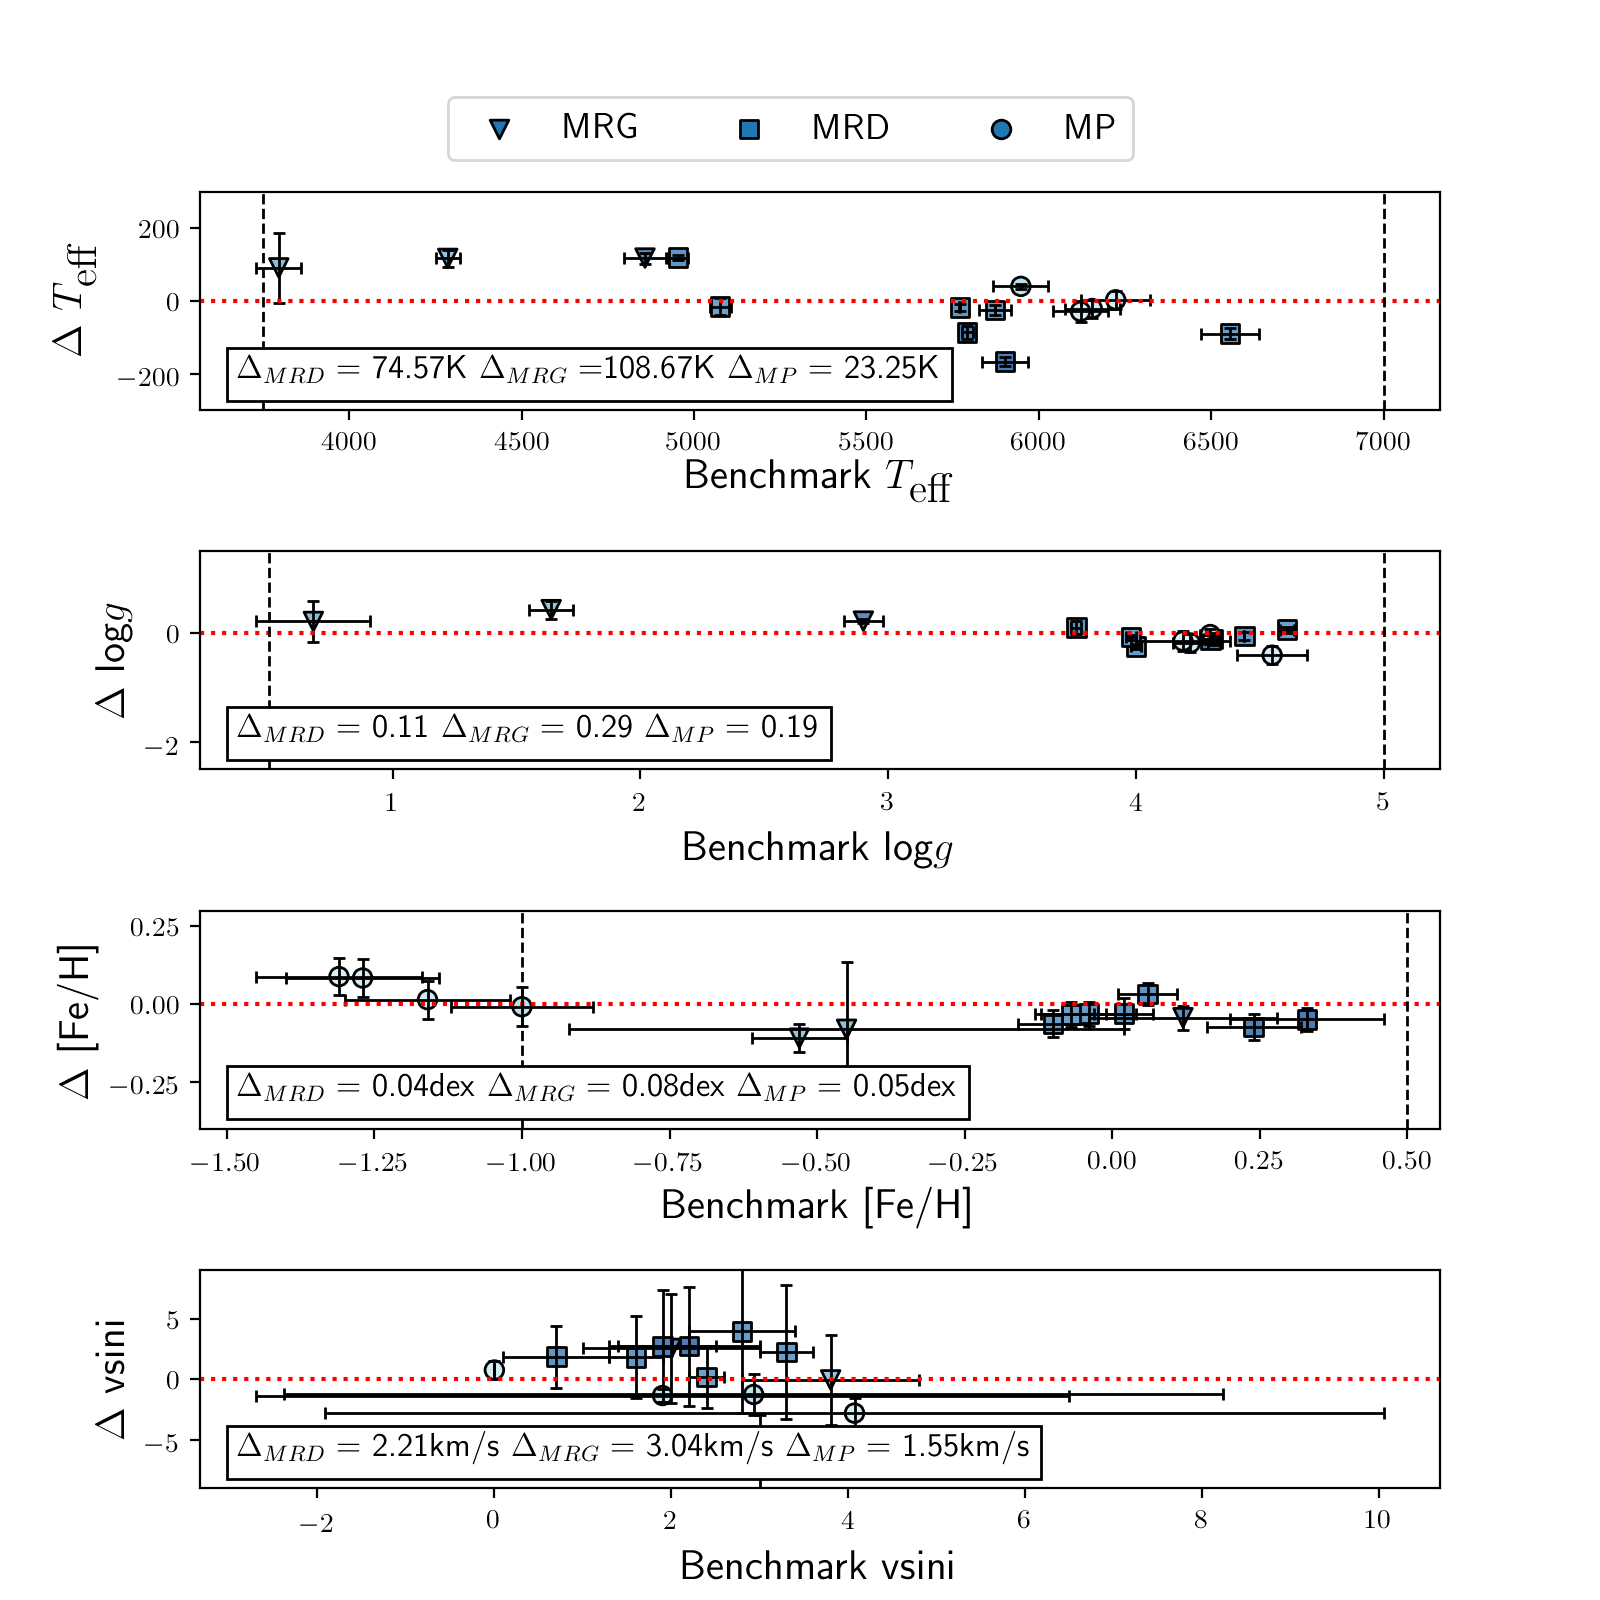

In [69]:
%matplotlib notebook
plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.grid']=True
plt.rcParams['grid.color']='gray'
plt.rcParams['grid.alpha']='0.4'
plt.rcParams["text.usetex"] = True
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1)
cm = plt.cm.get_cmap('RdYlBu')
fig = plt.figure(figsize=(8, 8)) 

params = ['Teff', 'logg', '[Fe/H]', 'vsini']
labels = [r'$T_{\textrm{eff}}$', r'log$g$', '[Fe/H]', 'vsini']
units = ['K', '', 'dex', 'km/s']
ylims = [(-300, 300),(-2.5, 1.5),(-0.4,0.3),(-9,9)]
grid_x_lims = [(3750, 7000),(0.5, 5.0),(-1.0, 0.5),(None,None)]

gs = gridspec.GridSpec(len(params), 1,  width_ratios=[1])
for i in range(len(params)):
    
    starnet_label = 'StarNet {}'.format(params[i])
    benchmark_label = params[i]
    err_name = 'e_{}'.format(params[i]) if params[i]=='vsini' else 'e{}'.format(params[i])
                                                  
    ax = plt.subplot(gs[i,0])
    # Plot MRGs
    x = MRG[benchmark_label]
    y = MRG[starnet_label] - MRG[benchmark_label]
    dy = MRG['StarNet {} unc.'.format(benchmark_label)]
    dx = MRG[err_name].astype(float)
    sc1 = plt.errorbar(x, y, xerr=dx, linestyle='None', capsize=2, elinewidth=1, ecolor='black')
    sc1 = plt.errorbar(x, y, yerr=dy, linestyle='None', capsize=2, elinewidth=1, ecolor='black')
    sc1 = plt.scatter(x, y, marker="v", label='MRGs', edgecolor='black',
                     c=MRG['[Fe/H]'], vmin=-5, vmax=1, s=45, cmap=cm)
    # Plot MRDs
    x = MRD[benchmark_label]
    y = MRD[starnet_label] - MRD[benchmark_label]
    dy = MRD['StarNet {} unc.'.format(benchmark_label)]
    dx = MRD[err_name].astype(float)
    sc2 = plt.errorbar(x, y, xerr=dx, linestyle='None', capsize=2, elinewidth=1, ecolor='black')
    sc2 = plt.errorbar(x, y, yerr=dy, linestyle='None', capsize=2, elinewidth=1, ecolor='black')
    sc2 = plt.scatter(x, y, marker="s", label='MRDs', edgecolor='black',
                     c=MRD['[Fe/H]'], vmin=-5, vmax=1, s=45, cmap=cm)
    # Plot MPs
    x = MP[benchmark_label]
    y = MP[starnet_label] - MP[params[i]]
    dy = MP['StarNet {} unc.'.format(benchmark_label)]
    dx = MP[err_name].astype(float)
    sc3 = plt.errorbar(x, y, xerr=dx, linestyle='None', capsize=2, elinewidth=1, ecolor='black')
    sc3 = plt.errorbar(x, y, yerr=dy, linestyle='None', capsize=2, elinewidth=1, ecolor='black')
    sc3 = plt.scatter(x, y, marker="o", label='MPs', edgecolor='black',
                     c=MP['[Fe/H]'], vmin=-5, vmax=1, s=45, cmap=cm)
    
    # Annotate subplot
    annotation = r'$\Delta_{{MRD}}=${0:6.2f}{1}'.format(aqd_MRD[i],units[i],width=6)
    annotation += r' $\Delta_{{MRG}}=${0:6.2f}{1}'.format(aqd_MRG[i],units[i],width=6)
    annotation += r' $\Delta_{{MP}}=${0:6.2f}{1}'.format(aqd_MP[i],units[i],width=6)
    ax.annotate(annotation, xy=(0.03, 0.12), xycoords='axes fraction', fontsize=12, bbox=bbox_props)
    plt.grid()
    plt.axhline(y=0, color='r', linestyle=':')
    plt.ylim(ylims[i])
    plt.xlabel(r'Benchmark {}'.format(labels[i]), size=15)
    plt.ylabel(r'$\Delta$ {}'.format(labels[i]), size=15)
    if grid_x_lims[i][0] is not None:
        plt.axvline(x=grid_x_lims[i][0], ls='--', lw=1, c='black')
        plt.axvline(x=grid_x_lims[i][1], ls='--', lw=1, c='black')
    
fig.subplots_adjust(wspace=.00, hspace=0.65, top=0.88, bottom=0.07)
#sc1.legend(bbox_to_anchor=(0., 1.02, 2.2, .102), loc=3,
#               ncol=4, mode="expand", borderaxespad=0)
fig.legend((sc1, sc2, sc3), ('MRG', 'MRD', 'MP'), (0.28, 0.9), ncol=3, fontsize=13)

## Comparisons of StarNet stellar parameter predictions versus the GES iDR4 values

### HR diagram

In [13]:
mist = MIST_Isochrone()

iso1 = mist.isochrone(9.8, -1.5)
iso2 = mist.isochrone(9.8, -1.0)
iso3 = mist.isochrone(9.8, -0.5)
iso4 = mist.isochrone(9.8, 0.0)
iso5 = mist.isochrone(9.8, 0.5)

indices_iso1 = (iso1['Teff'] > 3750) & (iso1['Teff'] < 7100)
indices_iso2 = (iso2['Teff'] > 3750) & (iso2['Teff'] < 7100)
indices_iso3 = (iso3['Teff'] > 3750) & (iso3['Teff'] < 7100)
indices_iso4 = (iso4['Teff'] > 3750) & (iso4['Teff'] < 7100)
indices_iso5 = (iso5['Teff'] > 3750) & (iso5['Teff'] < 7100)

<IPython.core.display.Javascript object>


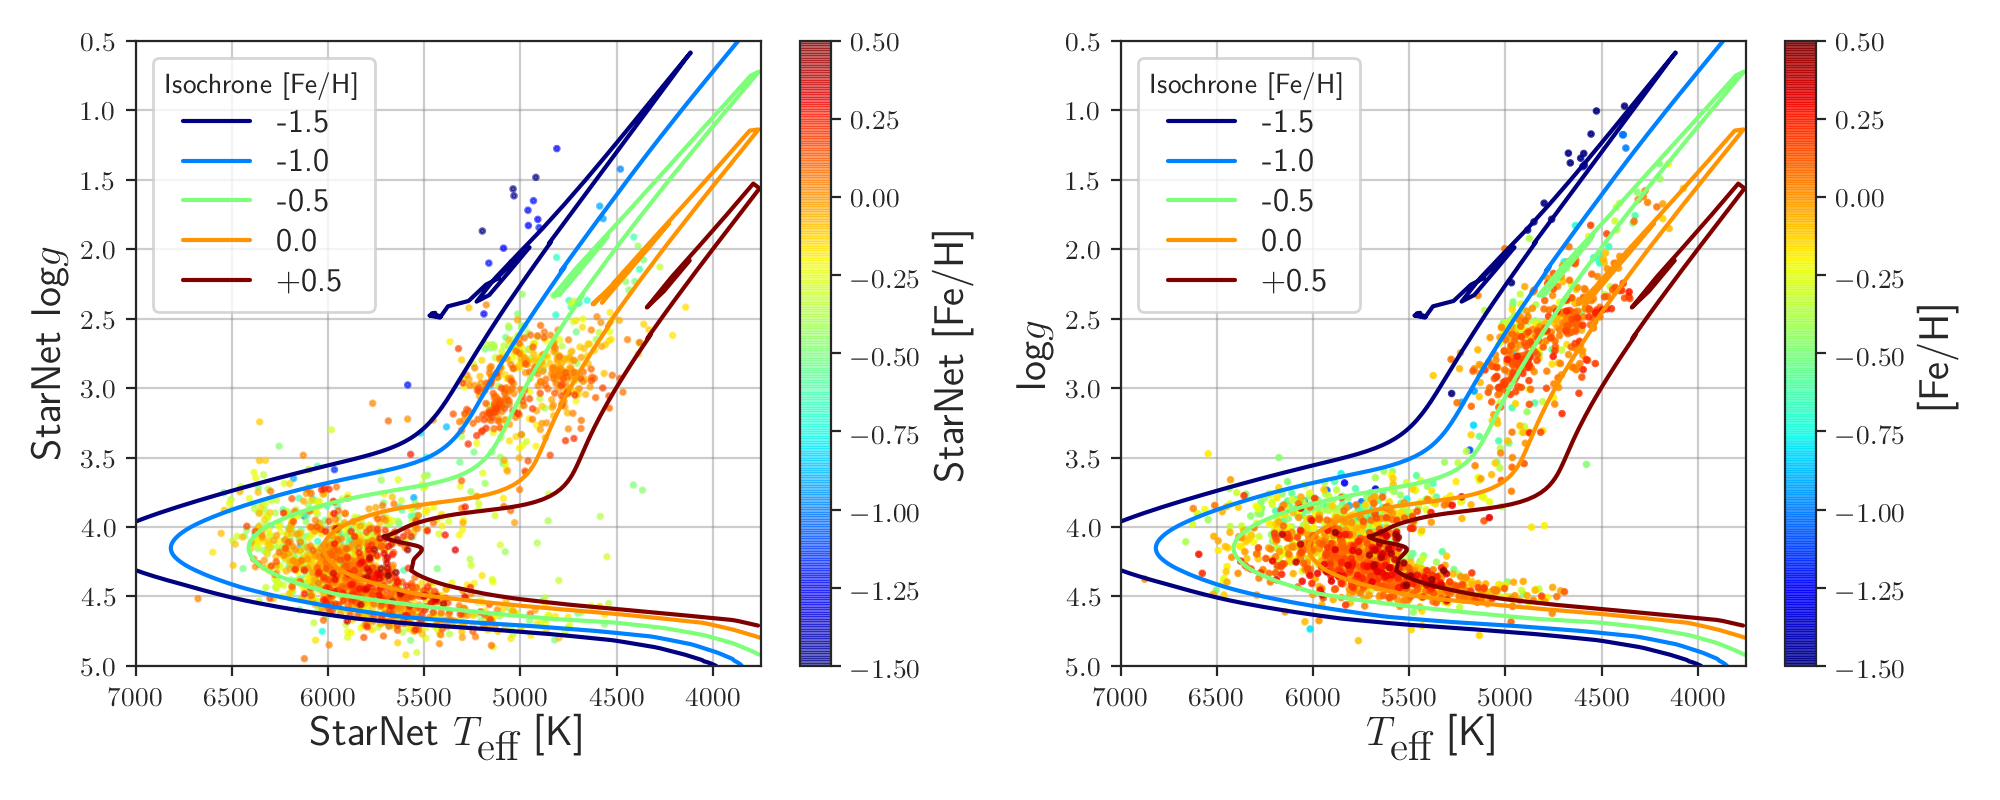

In [19]:
%matplotlib notebook
all_pred = mu_uves_highSNR[:,[0,1,2,5]]
all_sigma = sigma_uves_highSNR
uves_data = y_uves_highSNR
snr = snr_uves_highSNR
cmap = matplotlib.cm.get_cmap('jet')

z_teff = all_sigma[:,0]
z_feh = all_sigma[:,2]
z_logg = all_sigma[:,1]
z_vrot = all_sigma[:,4]
z_vrad = all_sigma[:,5]
indices_teff = z_teff<65
indices_feh = z_feh<0.51
indices_logg = z_logg<0.83
indices_vrot = z_vrot<3
indices_vrad = z_vrad<5
indices_snr = snr>0
indices = indices_teff & indices_feh & indices_logg & indices_vrad & indices_vrot & indices_snr# & mw_indices
all_pred = all_pred[indices]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
order1 = (all_pred[:,2]).reshape(all_pred[:,2].shape[0], ).argsort()
x_data1 = all_pred[:,0][order1]
y_data1 = all_pred[:,1][order1]
#c = sigma_uves[:,1][indices][order]
#c = snr[indices]
c = all_pred[:,2][order1]
im1 = axes[0].scatter(x_data1, y_data1, c=c, s=3, cmap='jet', vmin=-1.5, vmax=0.5, alpha=0.6)
cutoff_idx = 250
norm = matplotlib.colors.Normalize(vmin=-1.5, vmax=0.5)
axes[0].plot(iso1['Teff'][indices_iso1][:cutoff_idx+100], iso1['logg'][indices_iso1][:cutoff_idx+100], 
             c=cmap(norm(-1.5)), label='-1.5')
axes[0].plot(iso2['Teff'][indices_iso2][:cutoff_idx+100], iso2['logg'][indices_iso2][:cutoff_idx+100], 
             c=cmap(norm(-1.0)), label='-1.0')
axes[0].plot(iso3['Teff'][indices_iso3][:cutoff_idx+60], iso3['logg'][indices_iso3][:cutoff_idx+60], 
             c=cmap(norm(-0.5)), label='-0.5')
axes[0].plot(iso4['Teff'][indices_iso4][:cutoff_idx+60], iso4['logg'][indices_iso4][:cutoff_idx+60], 
             c=cmap(norm(0.0)), label='0.0')
axes[0].plot(iso5['Teff'][indices_iso5][:cutoff_idx], iso5['logg'][indices_iso5][:cutoff_idx], 
             c=cmap(norm(0.5)), label='+0.5')
fig.colorbar(im1, ax=axes[0]).set_label(label='StarNet [Fe/H]',size=15,weight='bold')
axes[0].invert_xaxis()
axes[0].invert_yaxis()
axes[0].legend(loc=0, title='Isochrone [Fe/H]', labelspacing=0.2, prop={'size': 12})
axes[0].set_xlabel(r'StarNet $T_{\textrm{eff}}$ [K]', size=15)
axes[0].set_ylabel(r'StarNet log$g$', size=15)
axes[0].set_xlim((7000,3750))
axes[0].set_ylim((5,0.5))

uves_data = uves_data[indices]
order = (uves_data[:,2]).reshape(uves_data[:,2].shape[0], ).argsort()
x_data = uves_data[:,0][order]
y_data = uves_data[:,1][order]

c = uves_data[:,2][order]
im2 = axes[1].scatter(x_data, y_data, c=c, s=3, cmap='jet', vmin=-1.5, vmax=0.5, alpha=0.8)
cutoff_idx = 250
axes[1].plot(iso1['Teff'][indices_iso1][:cutoff_idx+100], iso1['logg'][indices_iso1][:cutoff_idx+100], 
             c=cmap(norm(-1.5)), label='-1.5')
axes[1].plot(iso2['Teff'][indices_iso2][:cutoff_idx+100], iso2['logg'][indices_iso2][:cutoff_idx+100], 
             c=cmap(norm(-1.0)), label='-1.0')
axes[1].plot(iso3['Teff'][indices_iso3][:cutoff_idx+60], iso3['logg'][indices_iso3][:cutoff_idx+60], 
             c=cmap(norm(-0.5)), label='-0.5')
axes[1].plot(iso4['Teff'][indices_iso4][:cutoff_idx+60], iso4['logg'][indices_iso4][:cutoff_idx+60], 
             c=cmap(norm(0.0)), label='0.0')
axes[1].plot(iso5['Teff'][indices_iso5][:cutoff_idx], iso5['logg'][indices_iso5][:cutoff_idx], 
             c=cmap(norm(0.5)), label='+0.5')
fig.colorbar(im2, ax=axes[1]).set_label(label='[Fe/H]',size=15,weight='bold')
axes[1].invert_xaxis()
axes[1].invert_yaxis()
axes[1].legend(loc=0, title='Isochrone [Fe/H]', labelspacing=0.2, prop={'size': 12})
axes[1].set_xlabel(r'$T_{\textrm{eff}}$ [K]', size=15)
axes[1].set_ylabel(r'log$g$', size=15)
axes[1].set_xlim((7000,3750))
axes[1].set_ylim((5,0.5))

plt.tight_layout()

### Residual plot

/home/merileo/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


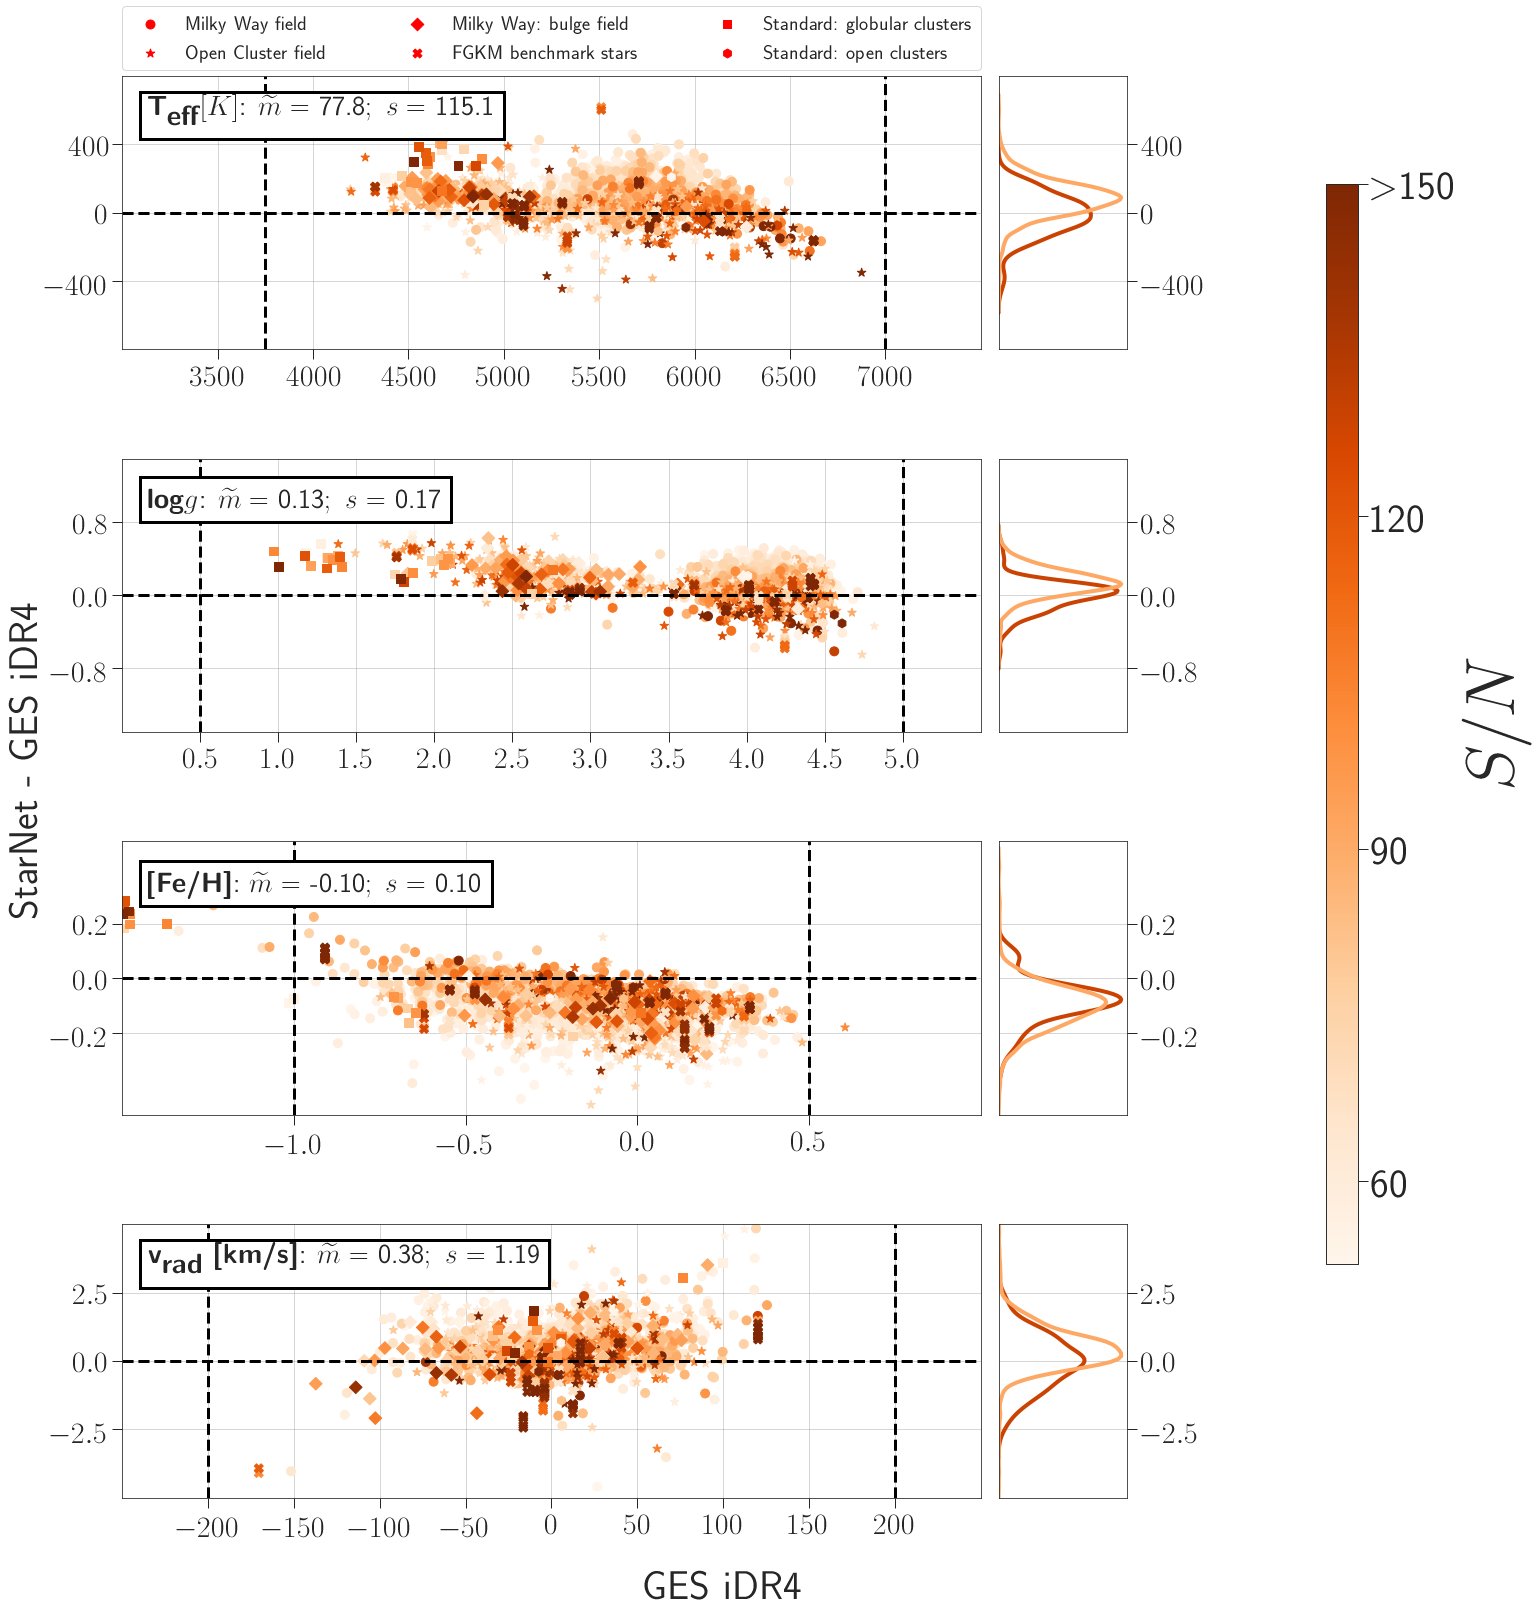

In [10]:
all_targets = y_uves[:,[0,1,2,3]]
all_pred = mu_uves[:,[0,1,2,5]]#,5,6]]
z_teff = sigma_uves[:,0]
z_feh = sigma_uves[:,2]
z_logg = sigma_uves[:,1]
z_vrot = sigma_uves[:,4]
z_vrad = sigma_uves[:,5]
indices_teff = z_teff<65
indices_feh = z_feh<0.51
indices_logg = z_logg<0.83
indices_vrot = z_vrot<3
indices_vrad = z_vrad<5
indices = indices_teff & indices_feh & indices_logg & indices_vrot & indices_vrad

all_targets = all_targets[indices]
all_pred = all_pred[indices]
z = snr_uves[indices]
ges_type_ = ges_type[indices]
#z = y_uves[:,3]
#z[np.isnan(z)] = 0
#z = snr_uves

groups_wanted = [b'GE_MW', b'GE_CL', b'GE_MW_BL', b'GE_SD_BM', b'GE_SD_GC', b'GE_SD_OC']

snr_max=150
x_lab=r'GES iDR4'
y_lab=r'StarNet - GES iDR4'
label_names = [r'T$_{\textbf{eff}} [K]$',r'log$g$',r'[Fe/H]',r'v$_\textbf{{rad}}$ [km/s]',r'v$_\textbf{{micro}}$']
cmap = 'Oranges'
plot_lims = [[3000., 7500.], [0.0, 5.5], [-1.5, 1.0], [-250, 250], [0.5, 2.2]]
resid_lims = [[-800., 800.], [-1.5, 1.5], [-0.5, 0.5], [-5, 5], [-1, 1]]
x_tick_stepsizes = [500, 0.5, 0.5, 50, 0.5]
grid_lims = [[3750., 7000.], [0.5, 5], [-1.0, 0.5], [-200, 200], [1., 2.]]


plot_compare_estimates_gaiaeso_resid(x_data=all_targets, 
                                     y_data=all_pred, 
                                     snr=z, 
                                     savename=None, 
                                     x_lab=x_lab, 
                                     y_lab=y_lab, 
                                     snr_max=snr_max, 
                                     cmap=cmap,
                                     label_names=label_names,
                                     lims=plot_lims,
                                     grid_lims=grid_lims,
                                     resid_lims=resid_lims,
                                     x_tick_steps=x_tick_stepsizes,
                                     indx=np.shape(all_targets)[1],
                                     categories=ges_type_,
                                     groups_wanted=groups_wanted)
#plt.savefig('demo.png', transparent=True)

### Examining the errors a little closer

<IPython.core.display.Javascript object>


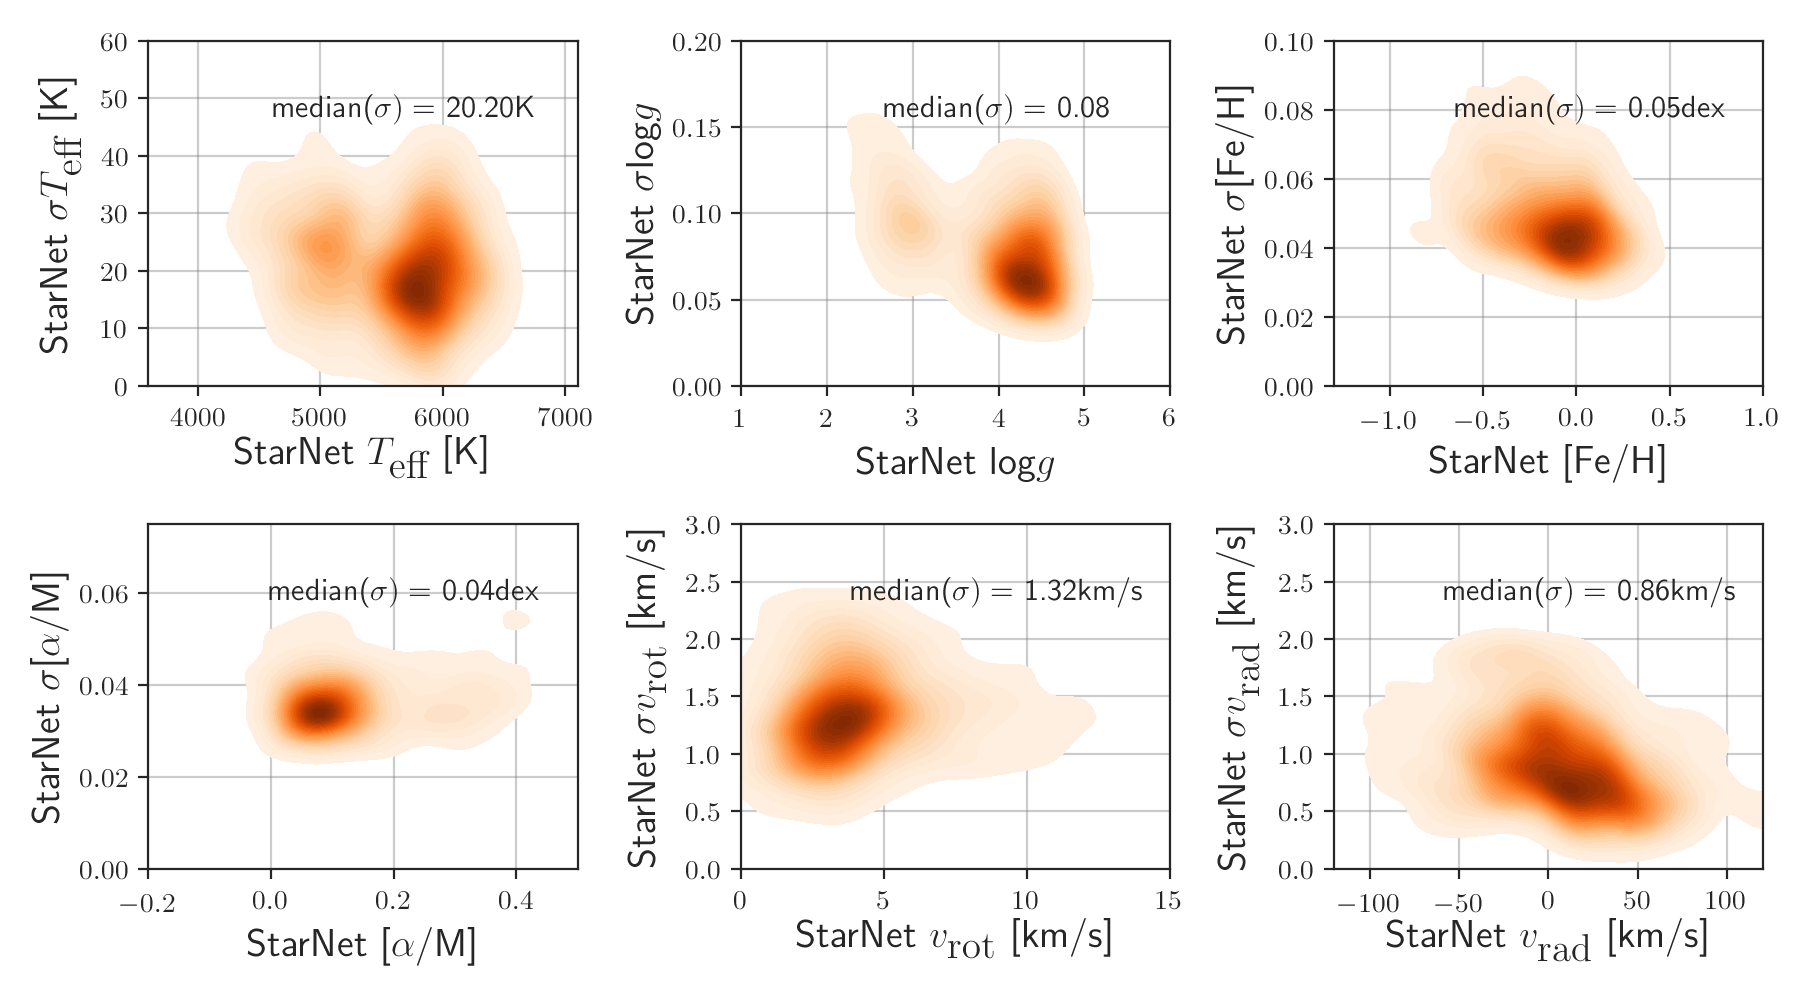

/home/merileo/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [20]:
%matplotlib notebook
label_names_x = [r'StarNet $T_{\textrm{eff}}$ [K]',r'StarNet log$g$',
               r'StarNet [Fe/H]',r'StarNet [$\alpha/$M]',
               r'StarNet $v_{\textrm{rot}}$ [km/s]', r'StarNet $v_{\textrm{rad}}$ [km/s]']
label_names_y = [r'StarNet $\sigma T_{\textrm{eff}}$ [K]',r'StarNet $\sigma$log$g$',
               r'StarNet $\sigma$[Fe/H]',r'StarNet $\sigma$[$\alpha/$M]',
               r'StarNet $\sigma v_{\textrm{rot}}$ [km/s]', r'StarNet $\sigma v_{\textrm{rad}}$ [km/s]']
units = ['K', '', 'dex', 'dex', 'km/s', 'km/s']
xlims = [(3600,7100), (1,6.0), (-1.3,1.0), (-0.2,0.5), (0, 15), (-120, 120)]
ylims = [(0,60), (0,0.2), (0,0.1), (0,0.075), (0,3), (0,3)]
indices_teff = sigma_uves[:,0]<150
indices_logg = sigma_uves[:,1]<1.5
indices_feh = sigma_uves[:,2]<1.5
indices_vrad = sigma_uves[:,5]<2
indices_vrot = sigma_uves[:,4]<2.5
indices = indices_teff & indices_feh & indices_logg & indices_vrad & indices_vrot

fig, axes = plt.subplots(2, 3, figsize=(9, 5))
for i in range(np.shape(sigma_uves)[1]):
    if i<3:
        ax = axes[0][i]
    else:
        ax = axes[1][i%3]
    sns.kdeplot(mu_uves[:,i][indices], sigma_uves[:,i][indices], shade=True, ax=ax, n_levels=30, cmap="Oranges",
                shade_lowest=False)
    ax.set_xlim(xlims[i])
    ax.set_ylim(ylims[i])
    ax.set_xlabel(label_names_x[i], size=14)
    ax.set_ylabel(label_names_y[i], size=14)
    ax.text(0.6, 0.80, r'median($\sigma) =$ {:.2f}{}'.format(np.median(sigma_uves[:,i][indices]), units[i]), horizontalalignment='center',
                    verticalalignment='center', transform=ax.transAxes, size=11)

plt.tight_layout()